## 1.1.1

In [1]:
import numpy as np
import scipy as sp
from scipy.linalg import null_space
from scipy import sparse

import networkx as nx
import matplotlib.pyplot as plt

from collections import Counter, defaultdict
import itertools
import random
import gc

# Reproducibility seed
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

In [2]:
N_NODES = 500          
K_NEIGHBORS = 4        
BETA = 0.3             
RHO = 0.7              
WEEKS = 15             
N_SIMULATIONS = 100    
INITIAL_INFECTED = 10  


SUSCEPTIBLE = 0
INFECTED = 1
RECOVERED = 2

In [ ]:
def create_k_regular_graph(n, k):
    rows = []
    cols = []

    # For each node i, neighbors are ±1, ±2 ... up to k/2
    half_k = k // 2

    for i in range(n):
        for offset in range(1, half_k + 1):
            # right neighbor (i + offset)
            neighbor_r = (i + offset) % n
            rows.append(i)
            cols.append(neighbor_r)

            # left neighbor (i - offset)
            neighbor_l = (i - offset) % n
            rows.append(i)
            cols.append(neighbor_l)

    data = np.ones(len(rows))
    adj_matrix = sparse.csr_matrix((data, (rows, cols)), shape=(n, n))
    return adj_matrix

In [4]:
def run_simulation(adj_matrix, n_nodes, weeks, beta, rho, initial_infected, initial_infected_choice='random'):
    # at the beginning all nodes are susceptible -> everyone is S = 0
    states = np.zeros(n_nodes, dtype=int)

    if initial_infected_choice == 'random':
        initial_infected_indices = np.random.choice(n_nodes, initial_infected, replace=False)
    elif initial_infected_choice == 'cluster':
        start_node = np.random.randint(0, n_nodes)
        initial_infected_indices = [(start_node + i) % n_nodes for i in range(initial_infected)]

    states[initial_infected_indices] = INFECTED

    # i = 0 for initial state, i = 1..15 for next weeks
    history_S = np.zeros(weeks + 1)
    history_I = np.zeros(weeks + 1)
    history_R = np.zeros(weeks + 1)
    new_infections_hist = np.zeros(weeks + 1)

    # initial state (t=0)
    history_S[0] = np.sum(states == SUSCEPTIBLE)
    history_I[0] = np.sum(states == INFECTED)
    history_R[0] = np.sum(states == RECOVERED)
    new_infections_hist[0] = initial_infected

    for t in range(weeks):
        # current infected nodes
        infected_mask = (states == INFECTED)

        # number of infected neighbors for each node
        m = adj_matrix.dot(infected_mask.astype(int))

        # P(S -> I) = 1 - (1 - beta)^m
        prob_infection = 1 - (1 - beta) ** m

        random_vals = np.random.rand(n_nodes)

        newly_infected_mask = (states == SUSCEPTIBLE) & (random_vals < prob_infection)

        # P(I -> R) = rho 
        random_vals_rec = np.random.rand(n_nodes)
        newly_recovered_mask = (states == INFECTED) & (random_vals_rec < rho)

        # states update synchronously given the discrete time nature of the model
        states[newly_infected_mask] = INFECTED
        states[newly_recovered_mask] = RECOVERED

        count_S = np.sum(states == SUSCEPTIBLE)
        count_I = np.sum(states == INFECTED)
        count_R = np.sum(states == RECOVERED)
        count_New_I = np.sum(newly_infected_mask)

        history_S[t+1] = count_S
        history_I[t+1] = count_I
        history_R[t+1] = count_R
        new_infections_hist[t+1] = count_New_I

    return history_S, history_I, history_R, new_infections_hist

### Simulation with random initial infected

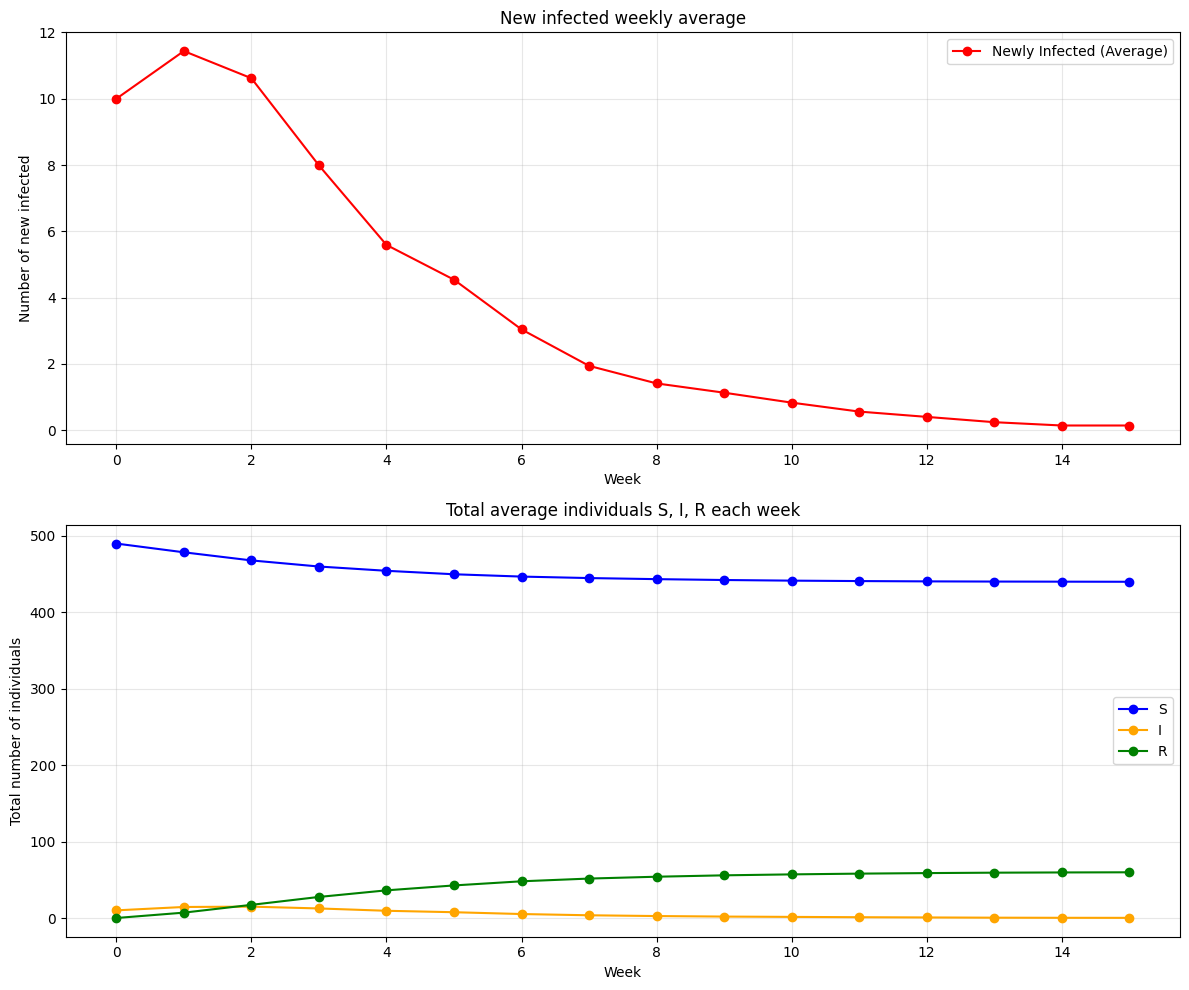

In [5]:
adj_matrix = create_k_regular_graph(N_NODES, K_NEIGHBORS)

total_S = np.zeros(WEEKS + 1)
total_I = np.zeros(WEEKS + 1)
total_R = np.zeros(WEEKS + 1)
total_new_I = np.zeros(WEEKS + 1)


for sim in range(N_SIMULATIONS):
    s, i, r, new_i = run_simulation(adj_matrix, N_NODES, WEEKS, BETA, RHO, INITIAL_INFECTED)
    total_S += s
    total_I += i
    total_R += r
    total_new_I += new_i

avg_S = total_S / N_SIMULATIONS
avg_I = total_I / N_SIMULATIONS
avg_R = total_R / N_SIMULATIONS
avg_new_I = total_new_I / N_SIMULATIONS

weeks_range = np.arange(WEEKS + 1)

def plot_epidemic(weeks, avg_S, avg_I, avg_R, avg_new_I):
    plt.figure(figsize=(12, 10))

    plt.subplot(2, 1, 1)
    plt.plot(weeks, avg_new_I, marker='o', color='red', linestyle='-', label='Newly Infected (Average)')
    plt.title('New infected weekly average')
    plt.xlabel('Week')
    plt.ylabel('Number of new infected')
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(weeks, avg_S, marker='o', label='S', color='blue')
    plt.plot(weeks, avg_I, marker='o', label='I', color='orange')
    plt.plot(weeks, avg_R, marker='o', label='R', color='green')
    plt.title('Total average individuals S, I, R each week')
    plt.xlabel('Week')
    plt.ylabel('Total number of individuals')
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_epidemic(weeks_range, avg_S, avg_I, avg_R, avg_new_I)

even trying different values of $\beta$ and $\rho$

- with $\beta \cdot k < \rho$: no peak
- with $\beta \cdot k \ge \rho$: peak but then the topology of the net still avoids the epidemic infecting all the population

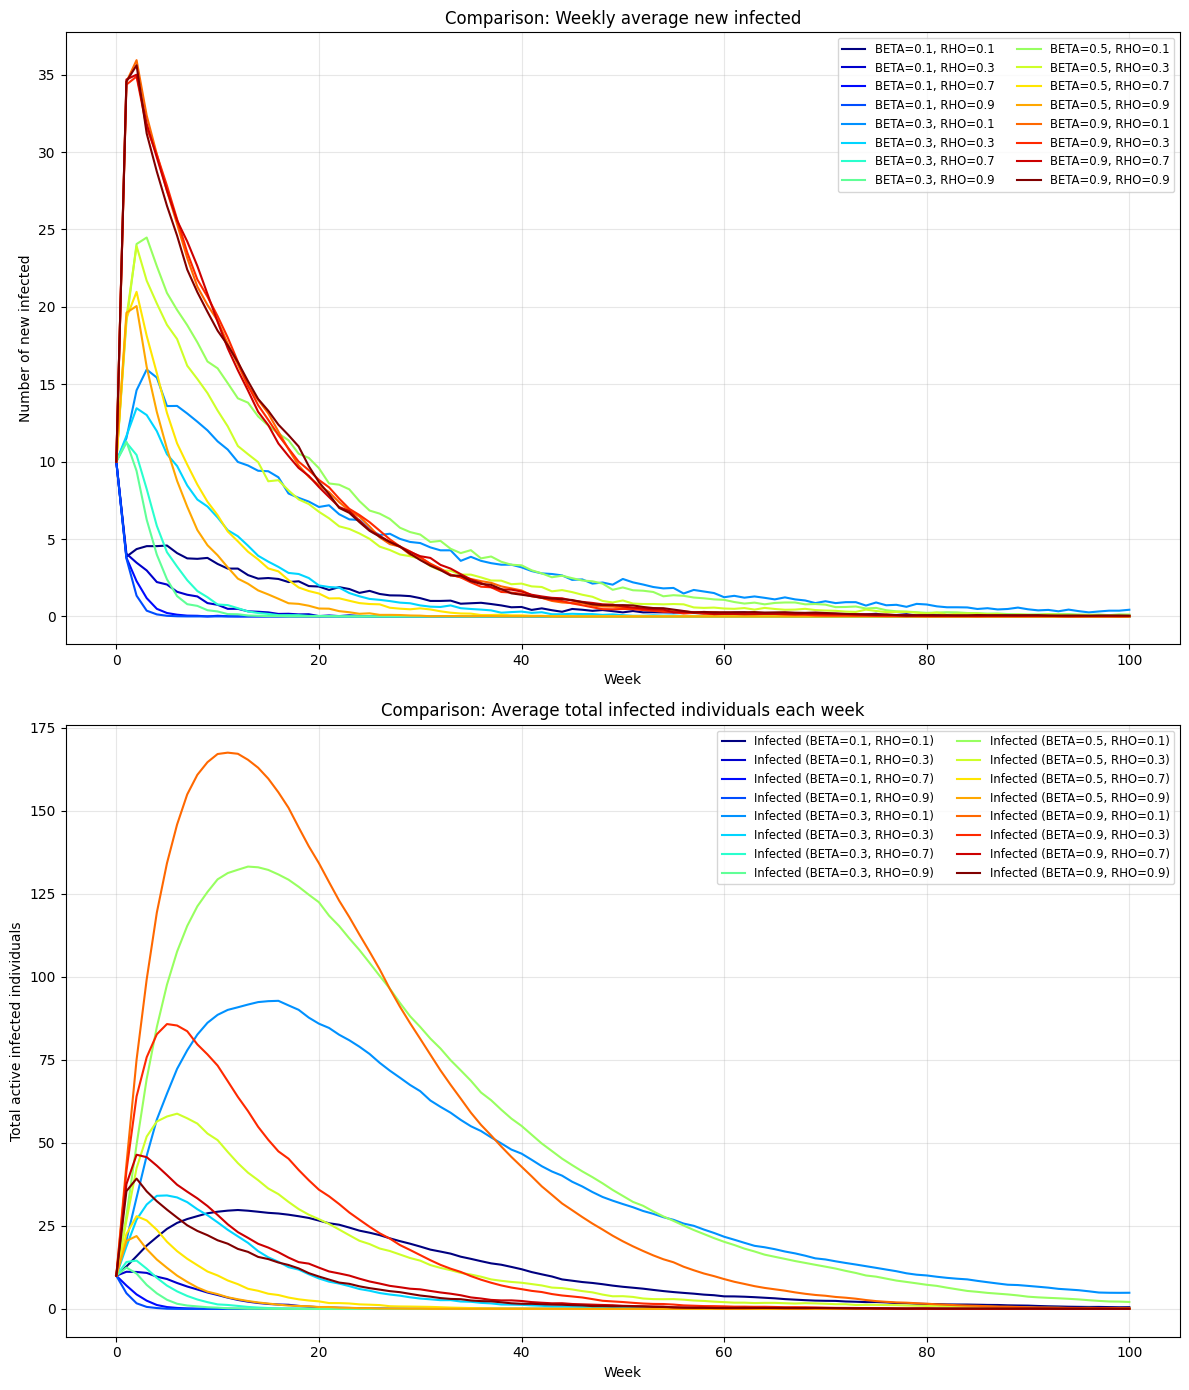

In [6]:
BETA = [0.1, 0.3, 0.5, 0.9]
RHO = [0.1, 0.3, 0.7, 0.9]
WEEKS = 100
weeks_range = np.arange(WEEKS + 1)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 14))

colors = plt.cm.jet(np.linspace(0, 1, len(BETA) * len(RHO))) 
c_idx = 0

for beta in BETA:
    for rho in RHO:
        
        total_S = np.zeros(WEEKS + 1)
        total_I = np.zeros(WEEKS + 1)
        total_R = np.zeros(WEEKS + 1)
        total_new_I = np.zeros(WEEKS + 1)

        for sim in range(N_SIMULATIONS):
            s, i, r, new_i = run_simulation(adj_matrix, N_NODES, WEEKS, beta, rho, INITIAL_INFECTED)
            total_S += s
            total_I += i
            total_R += r
            total_new_I += new_i

        avg_S = total_S / N_SIMULATIONS
        avg_I = total_I / N_SIMULATIONS
        avg_R = total_R / N_SIMULATIONS
        avg_new_I = total_new_I / N_SIMULATIONS

        label_sim = f'BETA={beta}, RHO={rho}'
        
        ax1.plot(weeks_range, avg_new_I, 
                 linestyle='-', 
                 label=label_sim, 
                 color=colors[c_idx])
        
        # just plot avg_I for readability
        ax2.plot(weeks_range, avg_I, 
                 linestyle='-', 
                 label=f'Infected ({label_sim})',
                 color=colors[c_idx])
        
        c_idx += 1

ax1.set_title('Comparison: Weekly average new infected')
ax1.set_xlabel('Week')
ax1.set_ylabel('Number of new infected')
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper right', fontsize='small', ncol=2)

ax2.set_title('Comparison: Average total infected individuals each week')
ax2.set_xlabel('Week')
ax2.set_ylabel('Total active infected individuals')
ax2.grid(True, alpha=0.3)
ax2.legend(loc='upper right', fontsize='small', ncol=2)

plt.tight_layout()
plt.show()

### Simulation with initial infected taken from a cluster

Choosing 10 neighbor nodes as initial infected, the epidemic dies out even faster because the initial infected shares the same suscepitble neighbors saturating the infection locally.

In a cluster, many of the links of infected nodes point to other already infected nodes within the group. These links are "wasted" because they cannot transmit the infection to new susceptible nodes. In the random configuration, however, almost all the links of the 10 infected nodes point to susceptible nodes, maximizing the probability of immediate expansion.

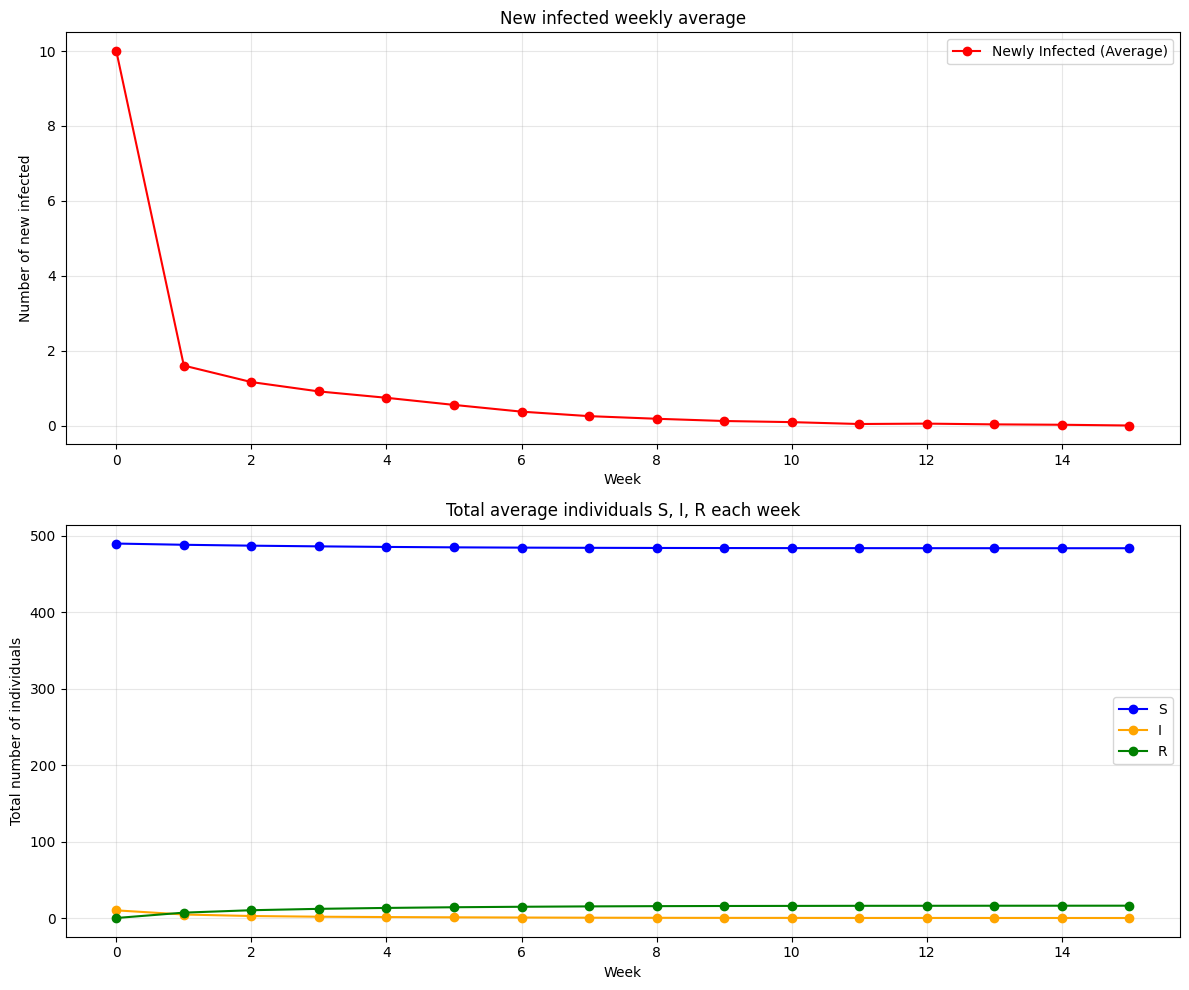

In [7]:
N_NODES = 500          
K_NEIGHBORS = 4        
BETA = 0.3             
RHO = 0.7              
WEEKS = 15             
N_SIMULATIONS = 100    
INITIAL_INFECTED = 10  

adj_matrix = create_k_regular_graph(N_NODES, K_NEIGHBORS)

total_S = np.zeros(WEEKS + 1)
total_I = np.zeros(WEEKS + 1)
total_R = np.zeros(WEEKS + 1)
total_new_I = np.zeros(WEEKS + 1)


for sim in range(N_SIMULATIONS):
    s, i, r, new_i = run_simulation(adj_matrix, N_NODES, WEEKS, BETA, RHO, INITIAL_INFECTED, initial_infected_choice='cluster')
    total_S += s
    total_I += i
    total_R += r
    total_new_I += new_i

avg_S = total_S / N_SIMULATIONS
avg_I = total_I / N_SIMULATIONS
avg_R = total_R / N_SIMULATIONS
avg_new_I = total_new_I / N_SIMULATIONS

weeks_range = np.arange(WEEKS + 1)
plot_epidemic(weeks_range, avg_S, avg_I, avg_R, avg_new_I)

### Simulation with different values of $k$ and initial infected

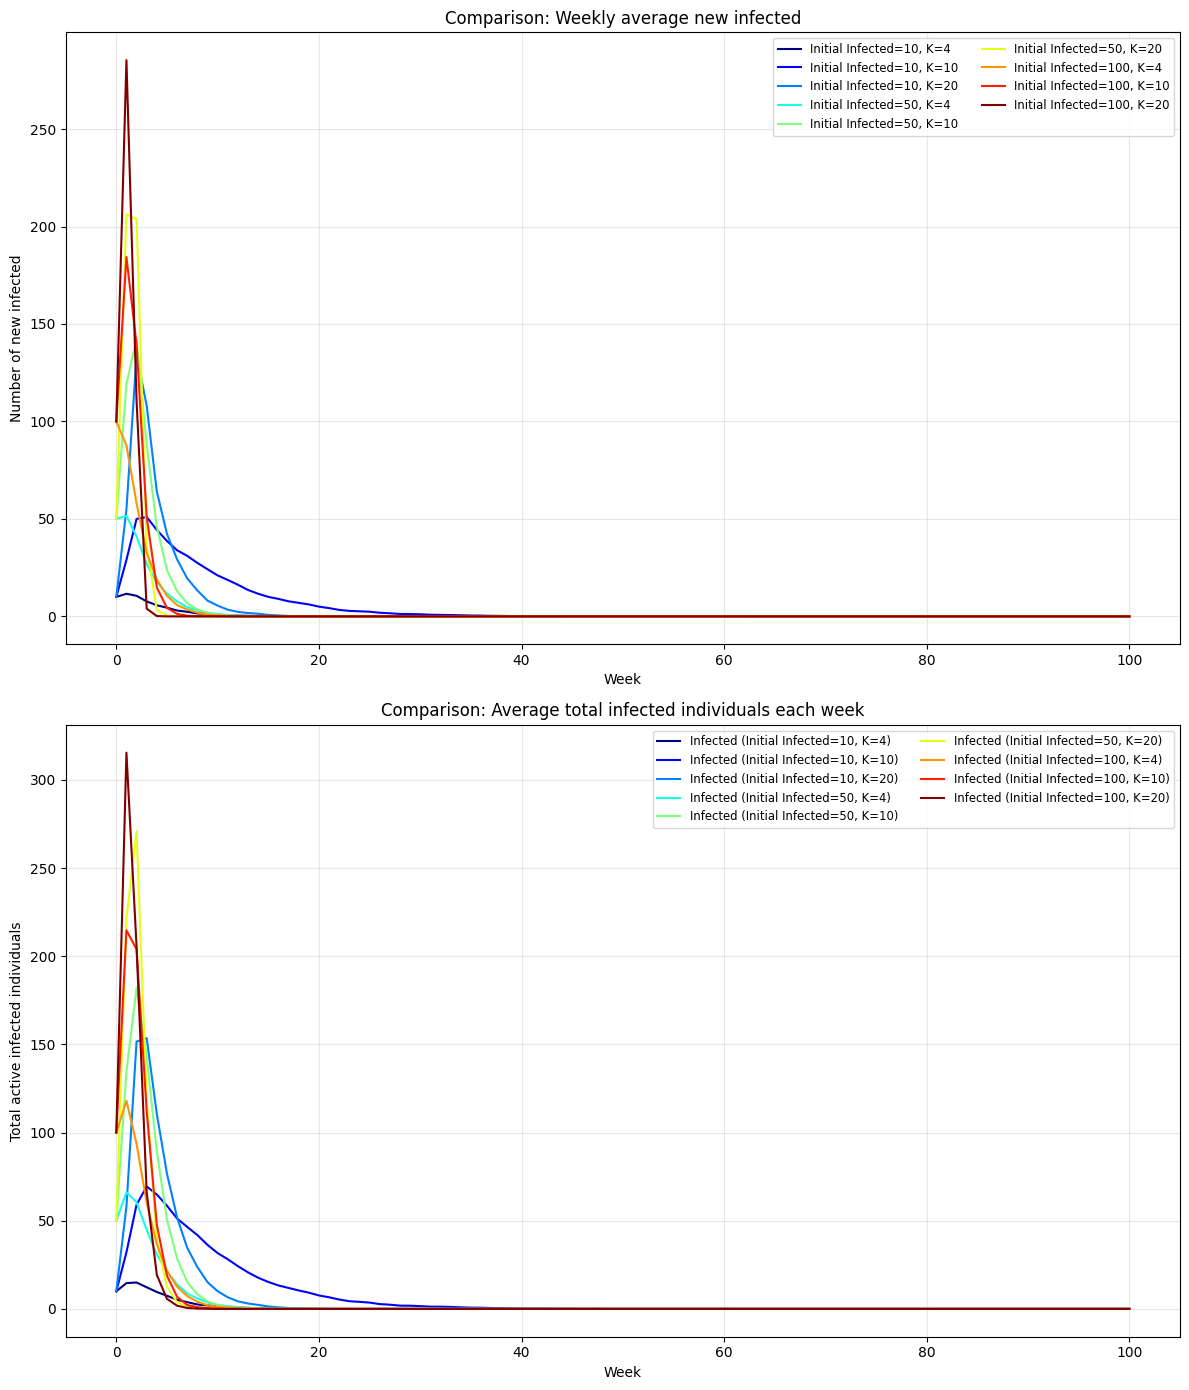

In [8]:
BETA = 0.3
RHO = 0.7
INITIAL_INFECTED = [10, 50, 100]
K_NEIGHBORS = [4, 10, 20]
WEEKS = 100
weeks_range = np.arange(WEEKS + 1)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 14))

colors = plt.cm.jet(np.linspace(0, 1, len(INITIAL_INFECTED) * len(K_NEIGHBORS))) 
c_idx = 0

for initial_infected in INITIAL_INFECTED:
    for k in K_NEIGHBORS:
        adj_matrix = create_k_regular_graph(N_NODES, k)
        
        total_S = np.zeros(WEEKS + 1)
        total_I = np.zeros(WEEKS + 1)
        total_R = np.zeros(WEEKS + 1)
        total_new_I = np.zeros(WEEKS + 1)

        for sim in range(N_SIMULATIONS):
            s, i, r, new_i = run_simulation(adj_matrix, N_NODES, WEEKS, BETA, RHO, initial_infected)
            total_S += s
            total_I += i
            total_R += r
            total_new_I += new_i

        avg_S = total_S / N_SIMULATIONS
        avg_I = total_I / N_SIMULATIONS
        avg_R = total_R / N_SIMULATIONS
        avg_new_I = total_new_I / N_SIMULATIONS

        label_sim = f'Initial Infected={initial_infected}, K={k}'
        
        ax1.plot(weeks_range, avg_new_I, 
                 linestyle='-', 
                 label=label_sim, 
                 color=colors[c_idx])
        
        # just plot avg_I for readability
        ax2.plot(weeks_range, avg_I, 
                 linestyle='-', 
                 label=f'Infected ({label_sim})',
                 color=colors[c_idx])
        
        c_idx += 1

ax1.set_title('Comparison: Weekly average new infected')
ax1.set_xlabel('Week')
ax1.set_ylabel('Number of new infected')
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper right', fontsize='small', ncol=2)

ax2.set_title('Comparison: Average total infected individuals each week')
ax2.set_xlabel('Week')
ax2.set_ylabel('Total active infected individuals')
ax2.grid(True, alpha=0.3)
ax2.legend(loc='upper right', fontsize='small', ncol=2)

plt.tight_layout()
plt.show()

## 1.1.2

In [ ]:
def generate_PA_graph(n_total, k):
    # INITIALIZATION (Time t=1)
    # Start with a complete graph (clique) of k+1 nodes
    # This ensures the initial average degree is exactly k.
    m0 = k + 1
    G = nx.complete_graph(m0)
    
    # Parameters for the alternating mechanism
    is_k_odd = (k % 2 != 0)
    c_floor = int(np.floor(k / 2))
    c_ceil = int(np.ceil(k / 2))
    
    # GROWTH (Time t >= 2)
    # We add nodes one by one from index m0 up to n_total - 1
    for new_node in range(m0, n_total):
        
        # Determine c (number of edges to add)
        if is_k_odd:
            # Alternate between floor and ceil
            # We use the node index to decide (even or odd step)
            if new_node % 2 == 0:
                c = c_floor
            else:
                c = c_ceil
        else:
            # If k is even, c is always k/2
            c = int(k / 2)
            
        # Get the list of existing nodes
        existing_nodes = np.array(G.nodes())
        
        # Get degrees of all existing nodes (w_i(t-1))
        # Note: G.degree() returns (node, degree) tuples, we just need the degrees
        degrees = np.array([G.degree(n) for n in existing_nodes])
        
        # Calculate the sum of degrees (Denominator of the formula)
        degree_sum = degrees.sum()
        
        # Calculate Probabilities
        # P(i) = w_i / sum(w)
        probabilities = degrees / degree_sum
        
        # Select 'c' targets based on these probabilities
        # replace=False ensures we do not add multiple links to the same node
        targets = np.random.choice(existing_nodes, size=c, replace=False, p=probabilities)
        
        # Add the new node and the edges
        G.add_node(new_node)
        for target in targets:
            G.add_edge(new_node, target)
            
    return G

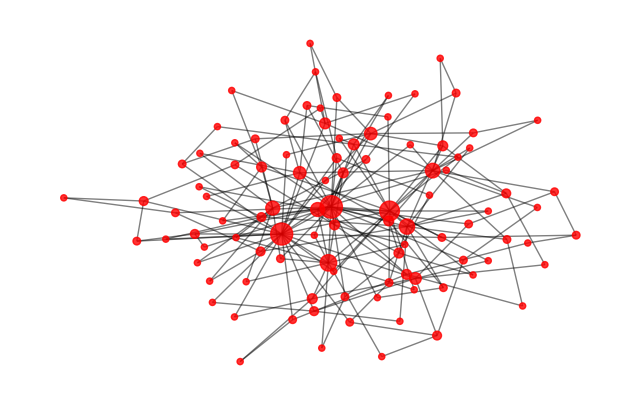

In [10]:
# Test out graph generation and visualize
G = generate_PA_graph(100, 4)

pos = nx.spring_layout(G, k=0.15, iterations=20, seed=42) 

d = dict(G.degree)
node_sizes = [v * 10 for v in d.values()] # Scale based on degree for visualization

plt.figure(figsize=(8, 5))
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='red', alpha=0.8)
nx.draw_networkx_edges(G, pos, alpha=0.5, edge_color='black')

plt.axis('off')
plt.show()

Target Average Degree: 8
Actual Average Degree: 8.0000


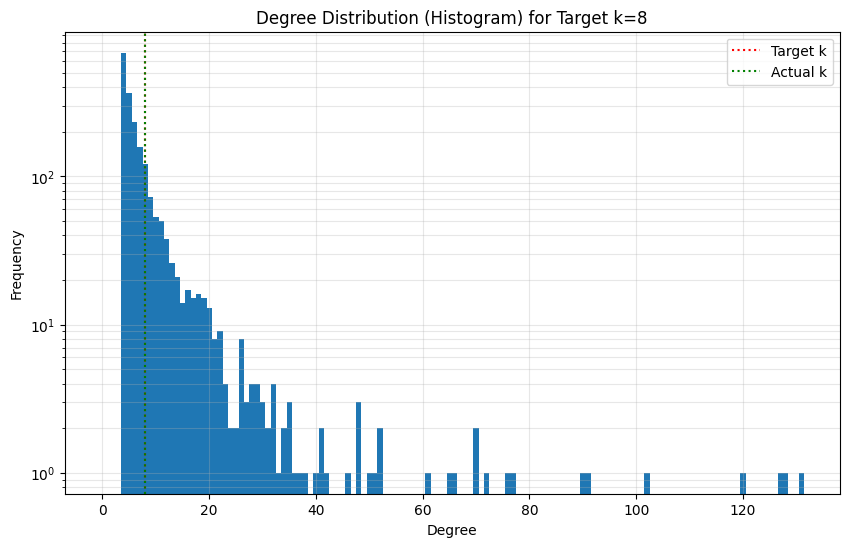

In [11]:
# Parameters
N = 2000     # Final number of nodes
K_TARGET = 8 # Target average degree (even number for default case)

# Generate Graph
G_pa = generate_PA_graph(N, K_TARGET)

# Compute Actual Average Degree
degrees = [d for n, d in G_pa.degree()]
k_actual = np.mean(degrees)

print(f"Target Average Degree: {K_TARGET}")
print(f"Actual Average Degree: {k_actual:.4f}")

plt.figure(figsize=(10, 6))

# Plot Degree Distribution
degree_sequence = [d for _, d in G_pa.degree()]
max_deg = max(degree_sequence)
plt.hist(degree_sequence, bins=range(0, max_deg + 2), align='left')
plt.axvline(x=K_TARGET, color='red', linestyle=':', label='Target k')
plt.axvline(x=k_actual, color='green', linestyle=':', label='Actual k')
plt.title(f"Degree Distribution (Histogram) for Target k={K_TARGET}")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.yscale('log')
plt.grid(True, alpha=0.3, which='both')
plt.legend()
plt.show()

Target Average Degree: 5
Actual Average Degree: 5.0000


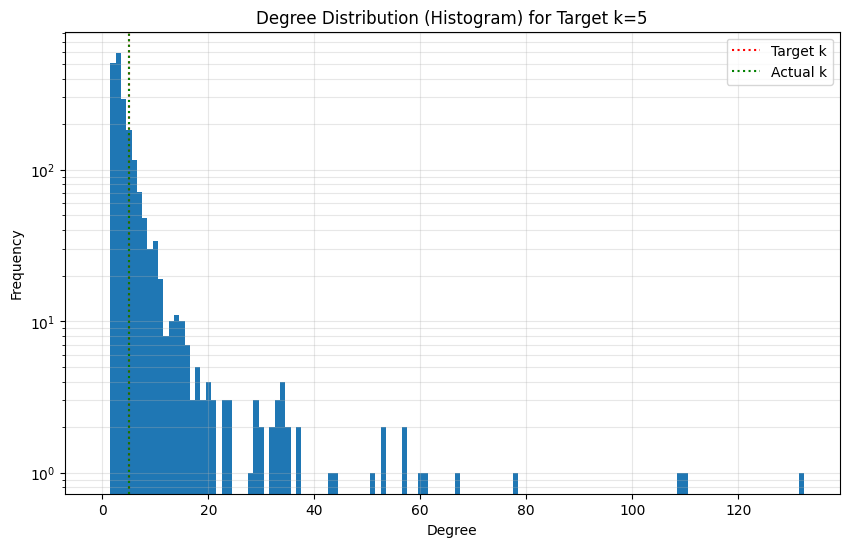

In [12]:
# Parameters
N = 2000     # Final number of nodes
K_TARGET = 5 # Target average degree (Odd number to test the tricky case)

# Generate Graph
G_pa = generate_PA_graph(N, K_TARGET)

# Compute Actual Average Degree
degrees = [d for n, d in G_pa.degree()]
k_actual = np.mean(degrees)

print(f"Target Average Degree: {K_TARGET}")
print(f"Actual Average Degree: {k_actual:.4f}")

plt.figure(figsize=(10, 6))

# Plot Degree Distribution
degree_sequence = [d for _, d in G_pa.degree()]
max_deg = max(degree_sequence)
plt.hist(degree_sequence, bins=range(0, max_deg + 2), align='left')
plt.axvline(x=K_TARGET, color='red', linestyle=':', label='Target k')
plt.axvline(x=k_actual, color='green', linestyle=':', label='Actual k')
plt.title(f"Degree Distribution (Histogram) for Target k={K_TARGET}")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.yscale('log')
plt.grid(True, alpha=0.3, which='both')
plt.legend()
plt.show()

## 1.2

Generating PA graph with N=500 and K=6...
Running simulations...


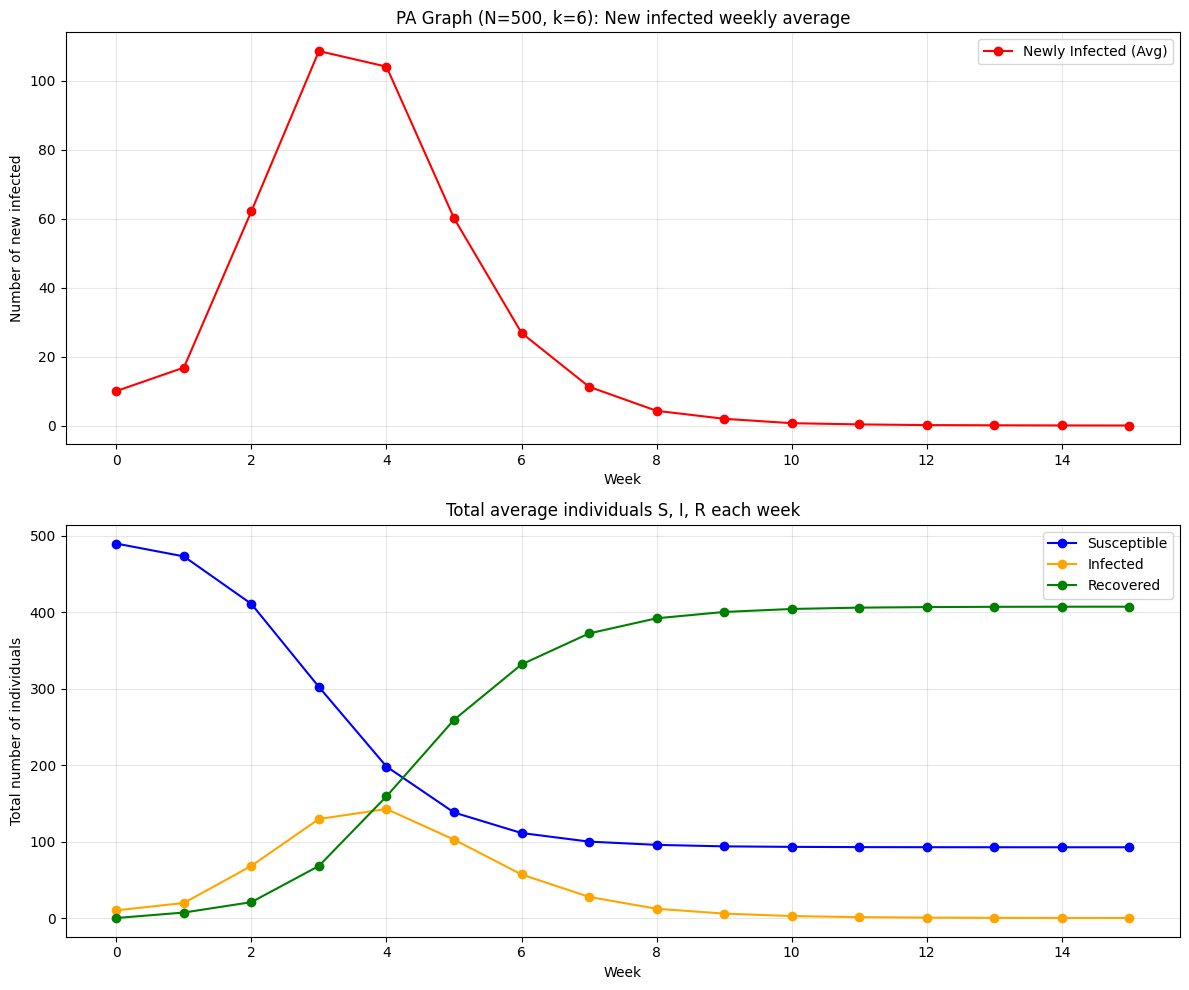

In [13]:
N_NODES =  500          # Graph size
K_TARGET = 6            # Target average degree
BETA = 0.3              # Infection rate
RHO = 0.7               # Recovery rate
WEEKS = 15              # Duration of simulation
N_SIMULATIONS = 100     # Number of runs to average
INITIAL_INFECTED = 10   # Number of initially infected nodes

print(f"Generating PA graph with N={N_NODES} and K={K_TARGET}...")
G_pa = generate_PA_graph(N_NODES, K_TARGET)
adj_matrix = nx.to_scipy_sparse_array(G_pa, format='csr')

print("Running simulations...")
total_S = np.zeros(WEEKS + 1)
total_I = np.zeros(WEEKS + 1)
total_R = np.zeros(WEEKS + 1)
total_new_I = np.zeros(WEEKS + 1)

for sim in range(N_SIMULATIONS):
    s, i, r, new_i = run_simulation(
        adj_matrix, 
        N_NODES, 
        WEEKS, 
        BETA, 
        RHO, 
        INITIAL_INFECTED, 
        initial_infected_choice='random'
    )
    total_S += s
    total_I += i
    total_R += r
    total_new_I += new_i

avg_S = total_S / N_SIMULATIONS
avg_I = total_I / N_SIMULATIONS
avg_R = total_R / N_SIMULATIONS
avg_new_I = total_new_I / N_SIMULATIONS

weeks_range = np.arange(WEEKS + 1)

def plot_epidemic_results(weeks, avg_S, avg_I, avg_R, avg_new_I):
    plt.figure(figsize=(12, 10))

    # Plot New Infections
    plt.subplot(2, 1, 1)
    plt.plot(weeks, avg_new_I, marker='o', color='red', linestyle='-', label='Newly Infected (Avg)')
    plt.title(f'PA Graph (N={N_NODES}, k={K_TARGET}): New infected weekly average')
    plt.xlabel('Week')
    plt.ylabel('Number of new infected')
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Plot SIR States
    plt.subplot(2, 1, 2)
    plt.plot(weeks, avg_S, marker='o', label='Susceptible', color='blue')
    plt.plot(weeks, avg_I, marker='o', label='Infected', color='orange')
    plt.plot(weeks, avg_R, marker='o', label='Recovered', color='green')
    plt.title('Total average individuals S, I, R each week')
    plt.xlabel('Week')
    plt.ylabel('Total number of individuals')
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_epidemic_results(weeks_range, avg_S, avg_I, avg_R, avg_new_I)

## 1.3

In [14]:
N_NODES =  500          # Graph size
K_TARGET = 6            # Target average degree
BETA = 0.3              # Infection rate
RHO = 0.7               # Recovery rate
WEEKS = 15              # Duration of simulation
N_SIMULATIONS = 100     # Number of runs to average
INITIAL_INFECTED = 10   # Number of initially infected nodes

VACCINATED = 3          # New state
VACCINATION_SCHEDULE_PCT = [0, 5, 15, 25, 35, 45, 55, 60, 60, 60, 60, 60, 60, 60, 60]   # Cumulative percentage of population vaccinated each week

In [15]:
def run_simulation_with_vaccination(adj_matrix, n_nodes, weeks, beta, rho, initial_infected, vacc_schedule_pct, initial_infected_choice='random'):
    # at the beginning all nodes are susceptible -> everyone is S = 0
    states = np.zeros(n_nodes, dtype=int)
    
    if initial_infected_choice == 'random':
        initial_infected_indices = np.random.choice(n_nodes, initial_infected, replace=False)
    elif initial_infected_choice == 'cluster':
        start_node = np.random.randint(0, n_nodes)
        initial_infected_indices = [(start_node + i) % n_nodes for i in range(initial_infected)]

    states[initial_infected_indices] = INFECTED
    
    # i = 0 for initial state, i = 1..15 for next weeks
    history_S = np.zeros(weeks + 1)
    history_I = np.zeros(weeks + 1)
    history_R = np.zeros(weeks + 1)
    history_V = np.zeros(weeks + 1)
    
    new_infections_hist = np.zeros(weeks + 1)
    new_vaccinations_hist = np.zeros(weeks + 1)
    
    # initial state (t=0)
    history_S[0] = np.sum(states == SUSCEPTIBLE)
    history_I[0] = np.sum(states == INFECTED)
    history_R[0] = np.sum(states == RECOVERED)
    history_V[0] = np.sum(states == VACCINATED)
    new_infections_hist[0] = initial_infected
    new_vaccinations_hist[0] = 0    # no vaccination happens in the initial state
    

    for t in range(weeks):
        # Compute  percentual of people that could be vaccinated during this week
        target_pct = vacc_schedule_pct[t]
        
        prev_pct = vacc_schedule_pct[t-1] if t > 0 else 0
        
        delta_pct = target_pct - prev_pct
        
        num_newly_vaccinated = 0
        
        if delta_pct > 0:
            num_to_vaccinate = int((delta_pct / 100.0) * n_nodes)
            
            # candidates who are not already vaccinated
            candidate_mask = (states != VACCINATED)
            candidate_indices = np.where(candidate_mask)[0]
            
            num_actual = min(num_to_vaccinate, len(candidate_indices))
            
            if num_actual > 0:
                chosen_indices = np.random.choice(candidate_indices, num_actual, replace=False)
                
                # Apply the Vaccination
                states[chosen_indices] = VACCINATED
                num_newly_vaccinated = num_actual

 
        # currently infected nodes
        infected_mask = (states == INFECTED)
        
        # number of infected neighbors for each node
        m = adj_matrix.dot(infected_mask.astype(int))
        
        # P(S -> I) = 1 - (1 - beta)^m
        prob_infection = 1 - (1 - beta) ** m
        
        random_vals = np.random.rand(n_nodes)
        
        newly_infected_mask = (states == SUSCEPTIBLE) & (random_vals < prob_infection)
        

        # P(I -> R) = rho 
        random_vals_rec = np.random.rand(n_nodes)
        newly_recovered_mask = (states == INFECTED) & (random_vals_rec < rho)
        
        # states update synchronously given the discrete time nature of the model
        states[newly_infected_mask] = INFECTED
        states[newly_recovered_mask] = RECOVERED
        
        history_S[t+1] = np.sum(states == SUSCEPTIBLE)
        history_I[t+1] = np.sum(states == INFECTED)
        history_R[t+1] = np.sum(states == RECOVERED)
        history_V[t+1] = np.sum(states == VACCINATED)
        
        new_infections_hist[t+1] = np.sum(newly_infected_mask)
        new_vaccinations_hist[t+1] = num_newly_vaccinated
        
    return history_S, history_I, history_R, history_V, new_infections_hist, new_vaccinations_hist

In [16]:
print(f"Generating PA graph with N={N_NODES} and K={K_TARGET}...")
G_pa_vacc = generate_PA_graph(N_NODES, K_TARGET)
adj_matrix_vacc = nx.to_scipy_sparse_array(G_pa_vacc, format='csr')

print("Running simulations with vaccination...")
total_S = np.zeros(WEEKS + 1)
total_I = np.zeros(WEEKS + 1)
total_R = np.zeros(WEEKS + 1)
total_V = np.zeros(WEEKS + 1)
total_new_I = np.zeros(WEEKS + 1)
total_new_V = np.zeros(WEEKS + 1)

for sim in range(N_SIMULATIONS):
    s, i, r, v, new_i, new_v = run_simulation_with_vaccination(
        adj_matrix_vacc, 
        N_NODES, 
        WEEKS, 
        BETA, 
        RHO, 
        INITIAL_INFECTED,
        VACCINATION_SCHEDULE_PCT,
        initial_infected_choice='random'
    )
    total_S += s
    total_I += i
    total_R += r
    total_V += v
    total_new_I += new_i
    total_new_V += new_v

avg_S = total_S / N_SIMULATIONS
avg_I = total_I / N_SIMULATIONS
avg_R = total_R / N_SIMULATIONS
avg_V = total_V / N_SIMULATIONS
avg_new_I = total_new_I / N_SIMULATIONS
avg_new_V = total_new_V / N_SIMULATIONS

weeks_range = np.arange(WEEKS + 1)

Generating PA graph with N=500 and K=6...
Running simulations with vaccination...


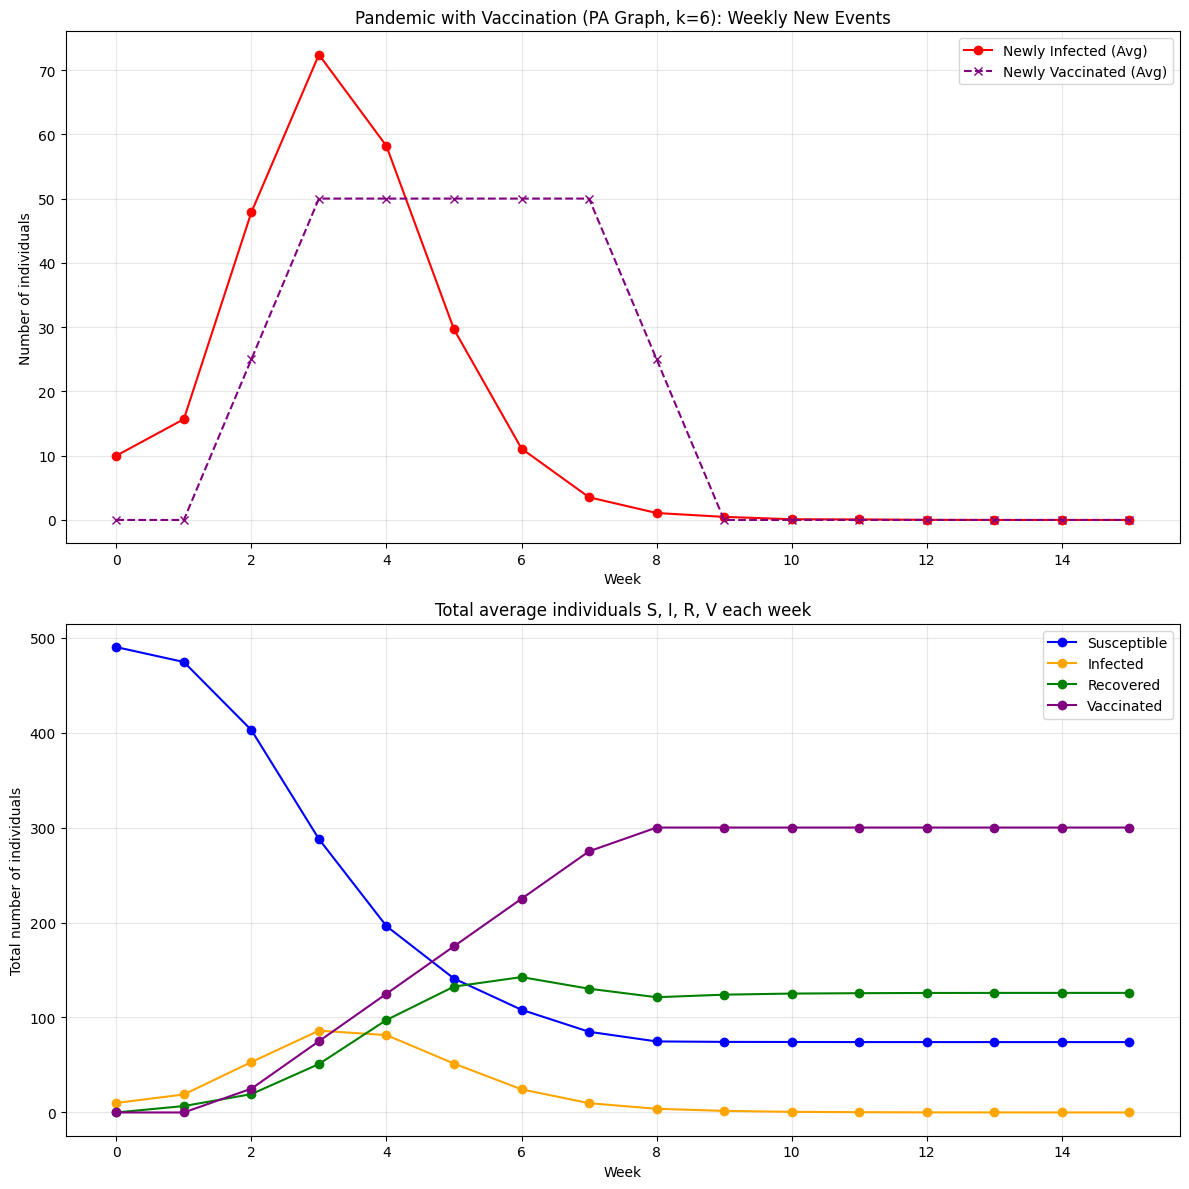

In [17]:
def plot_epidemic_with_vaccination_results(weeks_range, avg_S, avg_I, avg_R, avg_V, avg_new_I, avg_new_V):
    plt.figure(figsize=(12, 12))

    # Plot New Infections and New Vaccinations
    plt.subplot(2, 1, 1)
    plt.plot(weeks_range, avg_new_I, marker='o', color='red', linestyle='-', label='Newly Infected (Avg)')
    plt.plot(weeks_range, avg_new_V, marker='x', color='purple', linestyle='--', label='Newly Vaccinated (Avg)')
    plt.title(f'Pandemic with Vaccination (PA Graph, k={K_TARGET}): Weekly New Events')
    plt.xlabel('Week')
    plt.ylabel('Number of individuals')
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Plot SIRV States
    plt.subplot(2, 1, 2)
    plt.plot(weeks_range, avg_S, marker='o', label='Susceptible', color='blue')
    plt.plot(weeks_range, avg_I, marker='o', label='Infected', color='orange')
    plt.plot(weeks_range, avg_R, marker='o', label='Recovered', color='green')
    plt.plot(weeks_range, avg_V, marker='o', label='Vaccinated', color='purple')
    plt.title('Total average individuals S, I, R, V each week')
    plt.xlabel('Week')
    plt.ylabel('Total number of individuals')
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.show()


plot_epidemic_with_vaccination_results(weeks_range, avg_S, avg_I, avg_R, avg_V, avg_new_I, avg_new_V)

In [18]:
# Dati del testo
VACC = [5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60]   # 15 settimane
I0 = np.array([1, 1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0], dtype=float)  # len=16

NODES = 934
WEEKS = 15
N = 10 

initial_infected = int(I0[0])

assert len(VACC) == WEEKS
assert len(I0) == WEEKS + 1

In [19]:
def simulate_avg_I_and_states(k, beta, rho):

    # Generate PA graph
    G = generate_PA_graph(NODES, int(k))
    adj = nx.to_scipy_sparse_array(G, format='csr')

    # Prepare variables for results
    total_new_I = np.zeros(WEEKS + 1)
    total_S = np.zeros(WEEKS + 1)
    total_I = np.zeros(WEEKS+ 1)
    total_R = np.zeros(WEEKS + 1)
    total_V = np.zeros(WEEKS + 1)

    # Simulate N times and average results
    for _ in range(N):
        S, I, R, V, new_I, new_V = run_simulation_with_vaccination(
            adj, NODES, WEEKS, beta, rho, initial_infected, VACC,
            initial_infected_choice='random'
        )
        total_S += S
        total_I += I
        total_R += R
        total_V += V
        total_new_I += new_I

    avg_S = total_S / N
    avg_I = total_I / N
    avg_R = total_R / N
    avg_V = total_V / N
    avg_new_I = total_new_I / N  

    rmse = np.sqrt((1/15) * np.sum((avg_new_I[1:] - I0[1:])**2))

    return rmse, avg_new_I, avg_S, avg_I, avg_R, avg_V


In [20]:
def fit_h1n1(k0=10, beta0=0.3, rho0=0.6, dk=1, db=0.1, dr=0.1):

    # Round initial parameters
    beta0 = round(beta0, 3)
    rho0  = round(rho0, 3)

    while True:
        # Generate the neighborhood
        k_space = [k0 - dk, k0, k0 + dk]
        b_space = [round(beta0 - db, 3), beta0, round(beta0 + db, 3)]
        r_space = [round(rho0 - dr, 3),  rho0, round(rho0 + dr, 3)]

        best_local = None  # (rmse, k, beta, rho, avg_new_I, avg_S, avg_I, avg_R, avg_V)

        # Explore each combination in the neighborhood
        for k in k_space:
            if k < 2:
                continue
            for beta in b_space:
                if beta < 0 or beta > 1:
                    continue
                for rho in r_space:
                    if rho < 0 or rho > 1:
                        continue

                    # Run simulation and compute RMSE
                    rmse, avg_new_I, avg_S, avg_I, avg_R, avg_V = simulate_avg_I_and_states(
                        int(k), float(beta), float(rho)
                    )

                    cand = (
                        rmse,
                        int(k),
                        round(beta, 3),
                        round(rho, 3),
                        avg_new_I, avg_S, avg_I, avg_R, avg_V
                    )

                    # Find the best among the current neighbors
                    if (best_local is None) or (cand[0] < best_local[0]):
                        best_local = cand

        # Extract the best parameters of this step
        rmse_best, k_best, beta_best, rho_best = best_local[:4]

        print(
            f"Best local configuration found, with RMSE={rmse_best:.4f} "
            f"(k={k_best}, beta={beta_best:.3f}, rho={rho_best:.3f})"
        )

        # Convergence check
        if (k_best == k0) and (beta_best == beta0) and (rho_best == rho0):
            print("Convergence reached. Returning best parameters.")
            return best_local

        # Updated neighborhood center
        k0, beta0, rho0 = k_best, beta_best, rho_best


In [21]:
best = fit_h1n1(k0=10, beta0=0.3, rho0=0.6, dk=1, db=0.1, dr=0.1)

rmse_best, k_best, beta_best, rho_best, avg_new_I, avg_S, avg_I, avg_R, avg_V = best

print("\n=== BEST PARAMETERS (global minimum found) ===")
print(f"k    = {k_best}")
print(f"beta = {beta_best}")
print(f"rho  = {rho_best}")
print(f"RMSE = {rmse_best:.4f}")


Best local configuration found, with RMSE=7.1632 (k=10, beta=0.200, rho=0.600)
Best local configuration found, with RMSE=8.7788 (k=10, beta=0.100, rho=0.700)
Best local configuration found, with RMSE=5.7729 (k=9, beta=0.200, rho=0.800)
Best local configuration found, with RMSE=6.8449 (k=9, beta=0.200, rho=0.800)
Convergence reached. Returning best parameters.

=== BEST PARAMETERS (global minimum found) ===
k    = 9
beta = 0.2
rho  = 0.8
RMSE = 6.8449


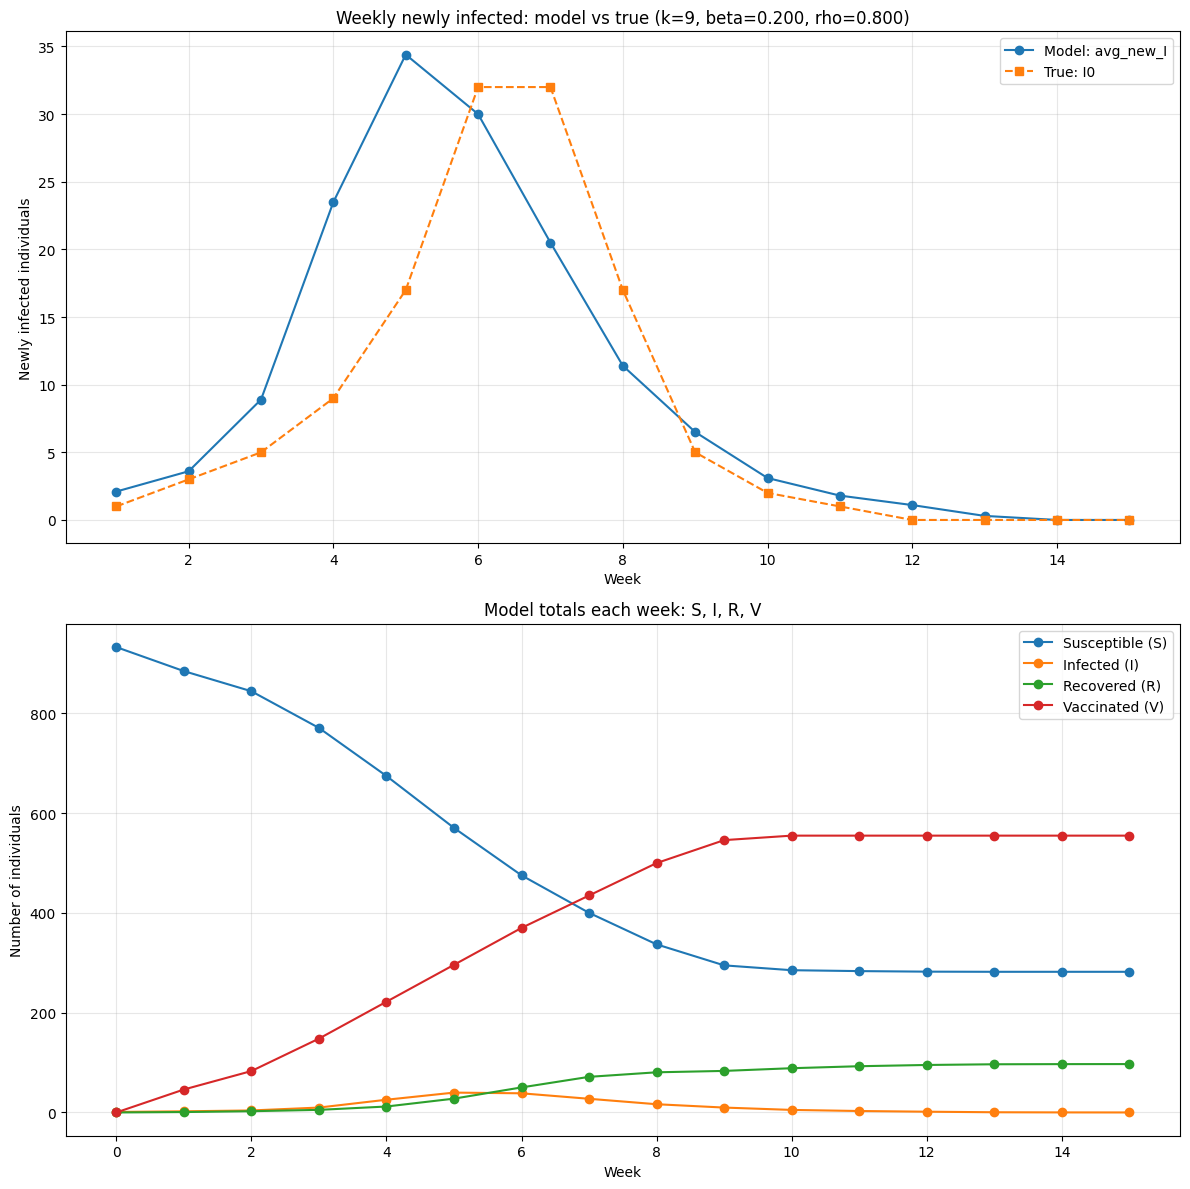

In [22]:
plt.figure(figsize=(12, 12))

# Simulation results vs true data
plt.subplot(2, 1, 1)
plt.plot(range(1, WEEKS + 1), avg_new_I[1:], marker='o', linestyle='-', label='Model: avg_new_I')
plt.plot(range(1, WEEKS + 1), I0[1:],        marker='s', linestyle='--', label='True: I0')
plt.title(f'Weekly newly infected: model vs true (k={k_best}, beta={beta_best:.3f}, rho={rho_best:.3f})')
plt.xlabel('Week')
plt.ylabel('Newly infected individuals')
plt.grid(True, alpha=0.3)
plt.legend()

# S, I, R, V totals
plt.subplot(2, 1, 2)
plt.plot(range(0, WEEKS + 1), avg_S, marker='o', label='Susceptible (S)')
plt.plot(range(0, WEEKS + 1), avg_I, marker='o', label='Infected (I)')
plt.plot(range(0, WEEKS + 1), avg_R, marker='o', label='Recovered (R)')
plt.plot(range(0, WEEKS + 1), avg_V, marker='o', label='Vaccinated (V)')
plt.title('Model totals each week: S, I, R, V')
plt.xlabel('Week')
plt.ylabel('Number of individuals')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()


In [23]:
def fit_h1n1_refine_adaptive_steps(
    k0=10, beta0=0.3, rho0=0.6,
    dk=1, db=0.1, dr=0.1,
    min_dk=1, min_db=0.005, min_dr=0.005,
    shrink=0.5,
    max_iters=200,
    round_p=6
):
    
    def quantize(k, b, r):
        return (int(k), round(float(b), round_p), round(float(r), round_p))

    k0, beta0, rho0 = quantize(k0, beta0, rho0)

    dk = int(dk)
    db = float(db)
    dr = float(dr)

    for iteration in range(max_iters):

        # Generate neighborhood for current center
        k_space = [k0 - dk, k0, k0 + dk]
        b_space = [beta0 - db, beta0, beta0 + db]
        r_space = [rho0  - dr, rho0,  rho0  + dr]

        best_local = None

        for k in k_space:
            if k < 2: continue
            k = int(k)

            for beta in b_space:
                if not (0 <= beta <= 1): continue
                beta = round(float(beta), round_p)

                for rho in r_space:
                    if not (0 <= rho <= 1): continue
                    rho = round(float(rho), round_p)

                    # Run simulation
                    sim_result = simulate_avg_I_and_states(k, beta, rho)
                    current_rmse = sim_result[0]

                    # If this is the best so far in the neighborhood, store it and clean up local variable
                    if (best_local is None) or (current_rmse < best_local[0]):
                        best_local = (
                            current_rmse, k, beta, rho,
                            sim_result[1], sim_result[2], sim_result[3], sim_result[4], sim_result[5]
                        )
                    del sim_result

        rmse_best, k_best, beta_best, rho_best = best_local[0], best_local[1], best_local[2], best_local[3]

        print(
            f"Iter {iteration}: Best RMSE={rmse_best:.4f} at (k={k_best}, b={beta_best:.3f}, r={rho_best:.3f}) "
            f"| steps: dk={dk}, db={db:.4f}, dr={dr:.4f}"
        )

        # Cleanup garbage collector, to free memory from local variables
        gc.collect()

        # Check if we are stuck
        stuck = (k_best == k0) and (beta_best == beta0) and (rho_best == rho0)
        if not stuck:
            k0, beta0, rho0 = k_best, beta_best, rho_best
            continue

        # If all steps are at their minimum, we have converged.
        if (dk <= min_dk) and (db <= min_db) and (dr <= min_dr):
            print("Convergence reached: minimum step sizes achieved.")
            return best_local

        # Else, shrink steps
        new_dk = max(min_dk, int(dk * shrink))
        if new_dk < min_dk: new_dk = min_dk

        new_db = max(min_db, round(db * shrink, round_p))
        new_dr = max(min_dr, round(dr * shrink, round_p))

        if (new_dk == dk) and (new_db == db) and (new_dr == dr):
            print("Steps cannot be shrunk further. Stopping.")
            return best_local

        dk, db, dr = new_dk, new_db, new_dr
        print(f" -> Stuck! Shrinking steps as: dk={dk}, db={db:.6f}, dr={dr:.6f}")

    print("Reached maximum iterations. Stopping.")
    return best_local


In [24]:
best = fit_h1n1_refine_adaptive_steps(
    k0=10, beta0=0.3, rho0=0.6,
    dk=3, db=0.1, dr=0.1,
    min_dk=1, min_db=0.01, min_dr=0.01
)

rmse_best, k_best, beta_best, rho_best, avg_new_I, avg_S, avg_I, avg_R, avg_V = best
print("\n=== BEST PARAMETERS (global minimum found) ===")
print(f"k = {k_best}")
print(f"beta = {beta_best}")
print(f"rho = {rho_best}")
print(f"RMSE = {rmse_best:.4f}")


Iter 0: Best RMSE=4.2621 at (k=7, b=0.200, r=0.500) | steps: dk=3, db=0.1000, dr=0.1000
Iter 1: Best RMSE=5.7393 at (k=7, b=0.200, r=0.500) | steps: dk=3, db=0.1000, dr=0.1000
 -> Stuck! Shrinking steps as: dk=1, db=0.050000, dr=0.050000
Iter 2: Best RMSE=4.5182 at (k=6, b=0.250, r=0.450) | steps: dk=1, db=0.0500, dr=0.0500
Iter 3: Best RMSE=5.1668 at (k=5, b=0.300, r=0.450) | steps: dk=1, db=0.0500, dr=0.0500
Iter 4: Best RMSE=4.4800 at (k=5, b=0.350, r=0.450) | steps: dk=1, db=0.0500, dr=0.0500
Iter 5: Best RMSE=5.0757 at (k=4, b=0.400, r=0.400) | steps: dk=1, db=0.0500, dr=0.0500
Iter 6: Best RMSE=3.5412 at (k=4, b=0.350, r=0.400) | steps: dk=1, db=0.0500, dr=0.0500
Iter 7: Best RMSE=4.1828 at (k=4, b=0.400, r=0.350) | steps: dk=1, db=0.0500, dr=0.0500
Iter 8: Best RMSE=3.5680 at (k=3, b=0.400, r=0.350) | steps: dk=1, db=0.0500, dr=0.0500
Iter 9: Best RMSE=3.9102 at (k=4, b=0.400, r=0.400) | steps: dk=1, db=0.0500, dr=0.0500
Iter 10: Best RMSE=5.0101 at (k=4, b=0.450, r=0.400) | ste

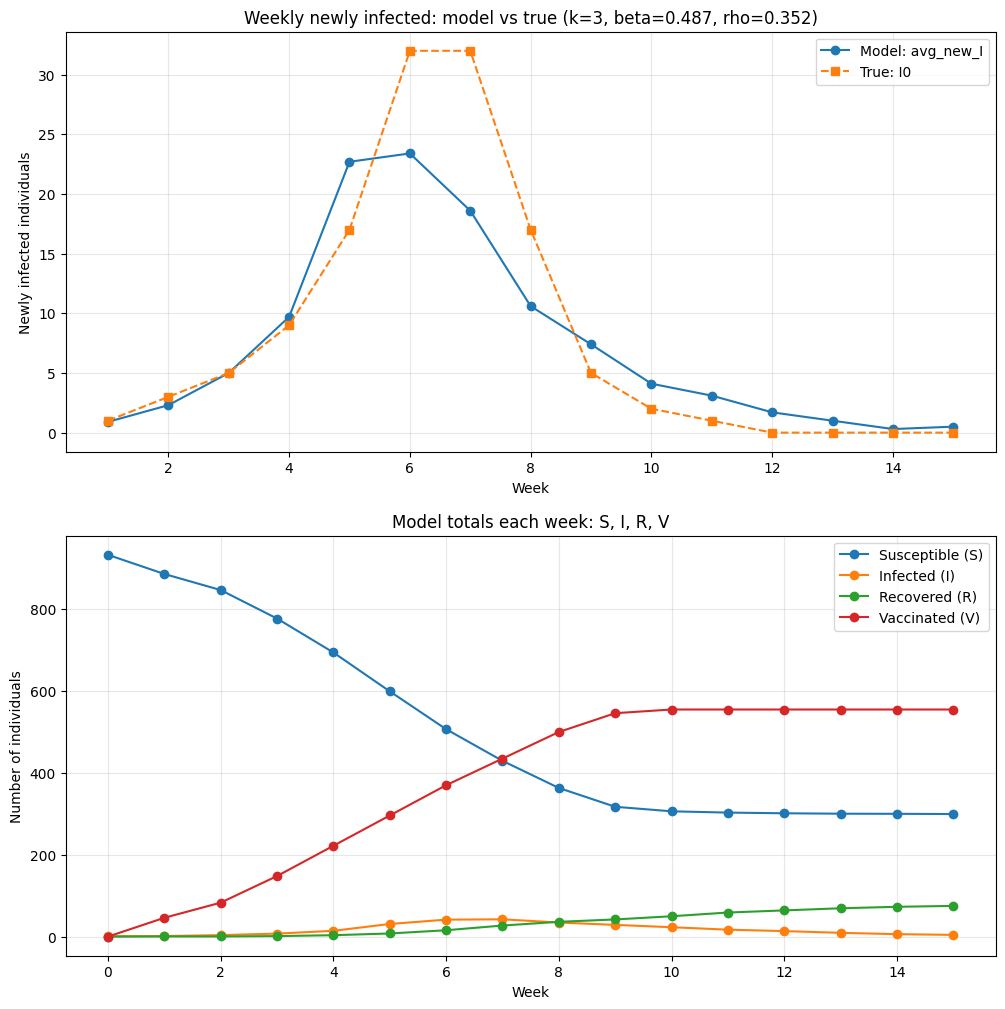

In [25]:
plt.figure(figsize=(12, 12))

# Simulation results vs true data
plt.subplot(2, 1, 1)
plt.plot(range(1, WEEKS + 1), avg_new_I[1:], marker='o', linestyle='-', label='Model: avg_new_I')
plt.plot(range(1, WEEKS + 1), I0[1:],        marker='s', linestyle='--', label='True: I0')
plt.title(f'Weekly newly infected: model vs true (k={k_best}, beta={beta_best:.3f}, rho={rho_best:.3f})')
plt.xlabel('Week')
plt.ylabel('Newly infected individuals')
plt.grid(True, alpha=0.3)
plt.legend()

# S, I, R, V totals
plt.subplot(2, 1, 2)
plt.plot(range(0, WEEKS + 1), avg_S, marker='o', label='Susceptible (S)')
plt.plot(range(0, WEEKS + 1), avg_I, marker='o', label='Infected (I)')
plt.plot(range(0, WEEKS + 1), avg_R, marker='o', label='Recovered (R)')
plt.plot(range(0, WEEKS + 1), avg_V, marker='o', label='Vaccinated (V)')
plt.title('Model totals each week: S, I, R, V')
plt.xlabel('Week')
plt.ylabel('Number of individuals')
plt.grid(True, alpha=0.3)
plt.legend()

## 1.5

#### Small World model

In [26]:
def generate_small_world_graph(n, k, p=0.05):
    # n: number of nodes
    # k: average degree neighbors
    # p: rewiring probability

    # Watts-Strogatz requires k to be even
    if k % 2 != 0:
        k += 1 

    G = nx.watts_strogatz_graph(n, k, p)
    return G

#### Holme-Kim model

In [27]:
def generate_holme_kim(n_nodes, m_edges, p_triangle=0.5):
    # n_nodes: number of nodes
    # m_edges: number of edges to attach from a new node to existing nodes
    # p_triangle: probability of adding a triangle after adding a random edge

    G = nx.powerlaw_cluster_graph(n=n_nodes, m=m_edges, p=p_triangle)
    return G

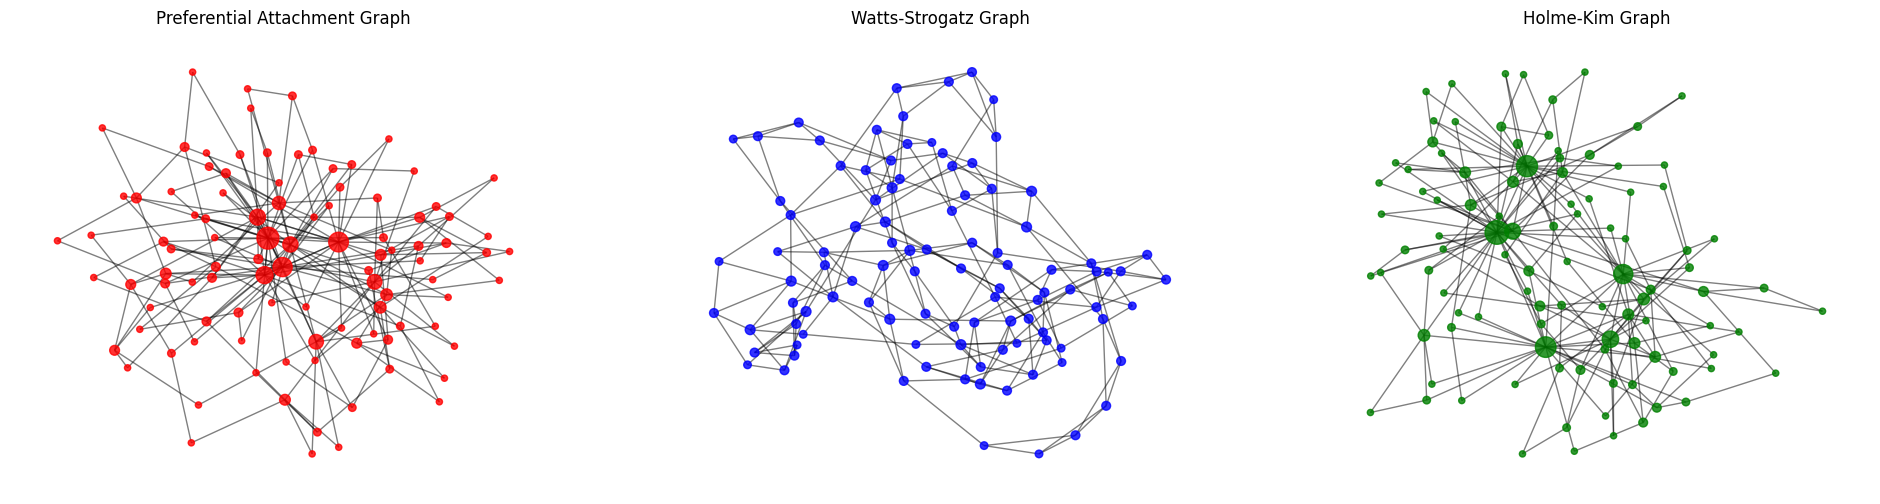

In [28]:
# Test out graph generation and visualize
PA_G = generate_PA_graph(100, 4)
WS_G = generate_small_world_graph(100, 4, p=0.1)
HK_G = generate_holme_kim(100, 2, p_triangle=0.5)

pa_pos = nx.spring_layout(PA_G, k=0.15, iterations=20, seed=42)
ws_pos = nx.spring_layout(WS_G, k=0.15, iterations=20, seed=42)
hk_pos = nx.spring_layout(HK_G, k=0.15, iterations=20, seed=42)

pa_d = dict(PA_G.degree)
ws_d = dict(WS_G.degree)
hk_d = dict(HK_G.degree)
pa_node_sizes = [v * 10 for v in pa_d.values()] # Scale based on degree for visualization
ws_node_sizes = [v * 10 for v in ws_d.values()] # Scale based on degree for visualization
hk_node_sizes = [v * 10 for v in hk_d.values()] # Scale based on degree for visualization

# Preferential Attachment Graph
plt.figure(figsize=(24, 6))
plt.subplot(1, 3, 1)
nx.draw_networkx_nodes(PA_G, pa_pos, node_size=pa_node_sizes, node_color='red', alpha=0.8)
nx.draw_networkx_edges(PA_G, pa_pos, alpha=0.5, edge_color='black')
plt.title("Preferential Attachment Graph")
plt.axis('off')

# Watts-Strogatz Graph
plt.subplot(1, 3, 2)
nx.draw_networkx_nodes(WS_G, ws_pos, node_size=ws_node_sizes, node_color='blue', alpha=0.8)
nx.draw_networkx_edges(WS_G, ws_pos, alpha=0.5, edge_color='black')
plt.title("Watts-Strogatz Graph")
plt.axis('off')

# Holme-Kim Graph
plt.subplot(1, 3, 3)
nx.draw_networkx_nodes(HK_G, hk_pos, node_size=hk_node_sizes, node_color='green', alpha=0.8)
nx.draw_networkx_edges(HK_G, hk_pos, alpha=0.5, edge_color='black')
plt.title("Holme-Kim Graph")
plt.axis('off')
plt.show()

In [29]:
def fit_generic_adaptive_steps(
    simulate_func,        # Simulation function to use
    initial_params,       # Initial parameter values [k0, beta0, rho0, ...]
    initial_steps,        # Initial step values [dk, db, dr, ...]
    min_steps,            # Minimal step values [min_dk, min_db, ...]
    bounds,               # Bounds for each param: [(min1, max1), (min2, max2), ...]
    param_types,          # Types for each param: [int, float, float, ...]
    shrink=0.5,
    max_iters=200,
    round_p=6
):

    # Helper function to clean and validate parameters
    def clean_param(val, p_type, bound):
        # Casting and rounding
        if p_type is int:
            val = int(round(val))
        else:
            val = round(float(val), round_p)

        # Check bounds
        if bound is not None:
            min_b, max_b = bound
            if min_b is not None and val < min_b: return None # Scarta
            if max_b is not None and val > max_b: return None # Scarta
        return val

    # Ensure inputs are lists and check lengths
    current_params = list(initial_params)
    current_steps = list(initial_steps)
    n_params = len(current_params)

    assert len(current_steps) == n_params
    assert len(min_steps) == n_params
    assert len(bounds) == n_params
    assert len(param_types) == n_params

    # Initial cleaning of starting parameters
    for i in range(n_params):
        cleaned = clean_param(current_params[i], param_types[i], bounds[i])
        if cleaned is None:
            raise ValueError(f"Initial parameter {i} out of bounds: {current_params[i]}")
        current_params[i] = cleaned

    for iteration in range(max_iters):

        # Generate search axes for each parameter
        search_axes = []
        for i in range(n_params):
            val = current_params[i]
            step = current_steps[i]

            # Generate raw candidates
            raw_candidates = [val - step, val, val + step]

            # Clean and validate candidates
            valid_candidates = []
            for cand in raw_candidates:
                c = clean_param(cand, param_types[i], bounds[i])
                if c is not None:
                    valid_candidates.append(c)

            # Remove duplicates and sort
            search_axes.append(sorted(list(set(valid_candidates))))

        best_local = None 

        # Explore the cartesian product of all parameter candidates
        for params_tuple in itertools.product(*search_axes):

            # Run simulation with the current parameter set
            sim_result = simulate_func(*params_tuple)

            # Extract RMSE
            current_rmse = sim_result[0]

            # Check if best in local neighborhood
            if (best_local is None) or (current_rmse < best_local[0]):
                best_local = (current_rmse, params_tuple) + sim_result[1:]

            # Clean up local variable
            del sim_result

        # Extract best parameters from local search so far
        rmse_best = best_local[0]
        best_params_tuple = best_local[1]

        # Log current best
        param_str = ", ".join([f"{p}" if isinstance(p, int) else f"{p:.3f}" for p in best_params_tuple])
        step_str = ", ".join([f"{s}" if isinstance(s, int) else f"{s:.4f}" for s in current_steps])
        print(f"Iter {iteration}: Best RMSE={rmse_best:.4f} at ({param_str}) | steps: [{step_str}]")

        # Cleanup garbage collector
        gc.collect()

        # Check if stuck
        is_stuck = (list(best_params_tuple) == current_params)
        if not is_stuck:
            current_params = list(best_params_tuple)
            continue

        # Check if all steps are at minimum
        all_min = True
        for i in range(n_params):
            if current_steps[i] > min_steps[i]:
                all_min = False
                break

        if all_min:
            print("Convergence reached: minimum step sizes achieved.")
            return best_local

        # Compute new shrunk steps
        new_steps = []
        unchanged_steps = True

        for i in range(n_params):
            old_s = current_steps[i]
            s_shrunk = old_s * shrink

            if param_types[i] is int:
                new_s = max(min_steps[i], int(s_shrunk))
            else:
                new_s = max(min_steps[i], round(s_shrunk, round_p))

            new_steps.append(new_s)
            if new_s != old_s:
                unchanged_steps = False

        if unchanged_steps:
            print("Convergence reached: steps cannot be shrunk further.")
            return best_local

        current_steps = new_steps
        step_debug = ", ".join([f"{s:.6f}" for s in current_steps])
        print(f" -> Stuck! Shrinking steps: {step_debug}")

    print("Converged: maximum iterations reached.")
    return best_local


In [30]:
def simulate(k, beta, rho, p, graph_generation_func=generate_small_world_graph, n_simulations=N):
    G = graph_generation_func(NODES, int(k), p)
    adj = nx.to_scipy_sparse_array(G, format='csr')

    total_new_I = np.zeros(WEEKS + 1)
    total_S = np.zeros(WEEKS + 1)
    total_I = np.zeros(WEEKS+ 1)
    total_R = np.zeros(WEEKS + 1)
    total_V = np.zeros(WEEKS + 1)

    for _ in range(n_simulations):
        S, I, R, V, new_I, new_V = run_simulation_with_vaccination(
            adj, NODES, WEEKS, beta, rho, initial_infected, VACC,
            initial_infected_choice='random'
        )
        total_S += S
        total_I += I
        total_R += R
        total_V += V
        total_new_I += new_I

    avg_S = total_S / n_simulations
    avg_I = total_I / n_simulations
    avg_R = total_R / n_simulations
    avg_V = total_V / n_simulations
    avg_new_I = total_new_I / n_simulations

    rmse = np.sqrt((1/15) * np.sum((avg_new_I[1:] - I0[1:])**2))

    return rmse, avg_new_I, avg_S, avg_I, avg_R, avg_V

#### Small World params estimation and plot

In [31]:
params_init = [10,  0.3, 0.6, 0.1]          # k0, beta0, rho0, p
steps_init  = [3,   0.1, 0.1, 0.01]         # dk, db, dr
min_steps   = [1,   0.01, 0.01, 0.005]      # min_dk, min_db, min_dr
p_types     = [int, float, float, float]    # types
p_bounds    = [ 
    # Bounds: k >= 2, 0 <= beta <= 1, 0 <= rho <= 1
    (2, None), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0)
]

best_result = fit_generic_adaptive_steps(
    simulate_func=simulate,
    initial_params=params_init,
    initial_steps=steps_init,
    min_steps=min_steps,
    bounds=p_bounds,
    param_types=p_types,
    shrink=0.5,
    max_iters=200
)

rmse_best = best_result[0]
k_best, beta_best, rho_best, p_best = best_result[1]
avg_new_I, avg_S, avg_I, avg_R, avg_V = best_result[2:]

Iter 0: Best RMSE=6.6633 at (10, 0.300, 0.700, 0.110) | steps: [3, 0.1000, 0.1000, 0.0100]
Iter 1: Best RMSE=6.1995 at (10, 0.300, 0.700, 0.110) | steps: [3, 0.1000, 0.1000, 0.0100]
 -> Stuck! Shrinking steps: 1.000000, 0.050000, 0.050000, 0.005000
Iter 2: Best RMSE=5.5766 at (9, 0.350, 0.750, 0.115) | steps: [1, 0.0500, 0.0500, 0.0050]
Iter 3: Best RMSE=5.6593 at (9, 0.350, 0.800, 0.115) | steps: [1, 0.0500, 0.0500, 0.0050]
Iter 4: Best RMSE=5.8125 at (10, 0.350, 0.800, 0.110) | steps: [1, 0.0500, 0.0500, 0.0050]
Iter 5: Best RMSE=5.6949 at (10, 0.350, 0.750, 0.105) | steps: [1, 0.0500, 0.0500, 0.0050]
Iter 6: Best RMSE=5.9179 at (9, 0.350, 0.800, 0.100) | steps: [1, 0.0500, 0.0500, 0.0050]
Iter 7: Best RMSE=5.7318 at (9, 0.350, 0.800, 0.100) | steps: [1, 0.0500, 0.0500, 0.0050]
 -> Stuck! Shrinking steps: 1.000000, 0.025000, 0.025000, 0.005000
Iter 8: Best RMSE=4.9470 at (10, 0.350, 0.825, 0.100) | steps: [1, 0.0250, 0.0250, 0.0050]
Iter 9: Best RMSE=5.7498 at (9, 0.325, 0.800, 0.095

In [32]:
print("\n=== BEST PARAMETERS (global minimum found) ===")
print(f"k = {k_best}")
print(f"beta = {beta_best}")
print(f"rho = {rho_best}")
print(f"p = {p_best}")
print(f"RMSE = {rmse_best:.3f}")
rmse, avg_new_I_sim, avg_S_sim, avg_I_sim, avg_R_sim, avg_V_sim = simulate(
     k_best, beta_best, rho_best, p_best, graph_generation_func=generate_small_world_graph, n_simulations=99
)


=== BEST PARAMETERS (global minimum found) ===
k = 10
beta = 0.3425
rho = 0.8125
p = 0.12
RMSE = 5.437


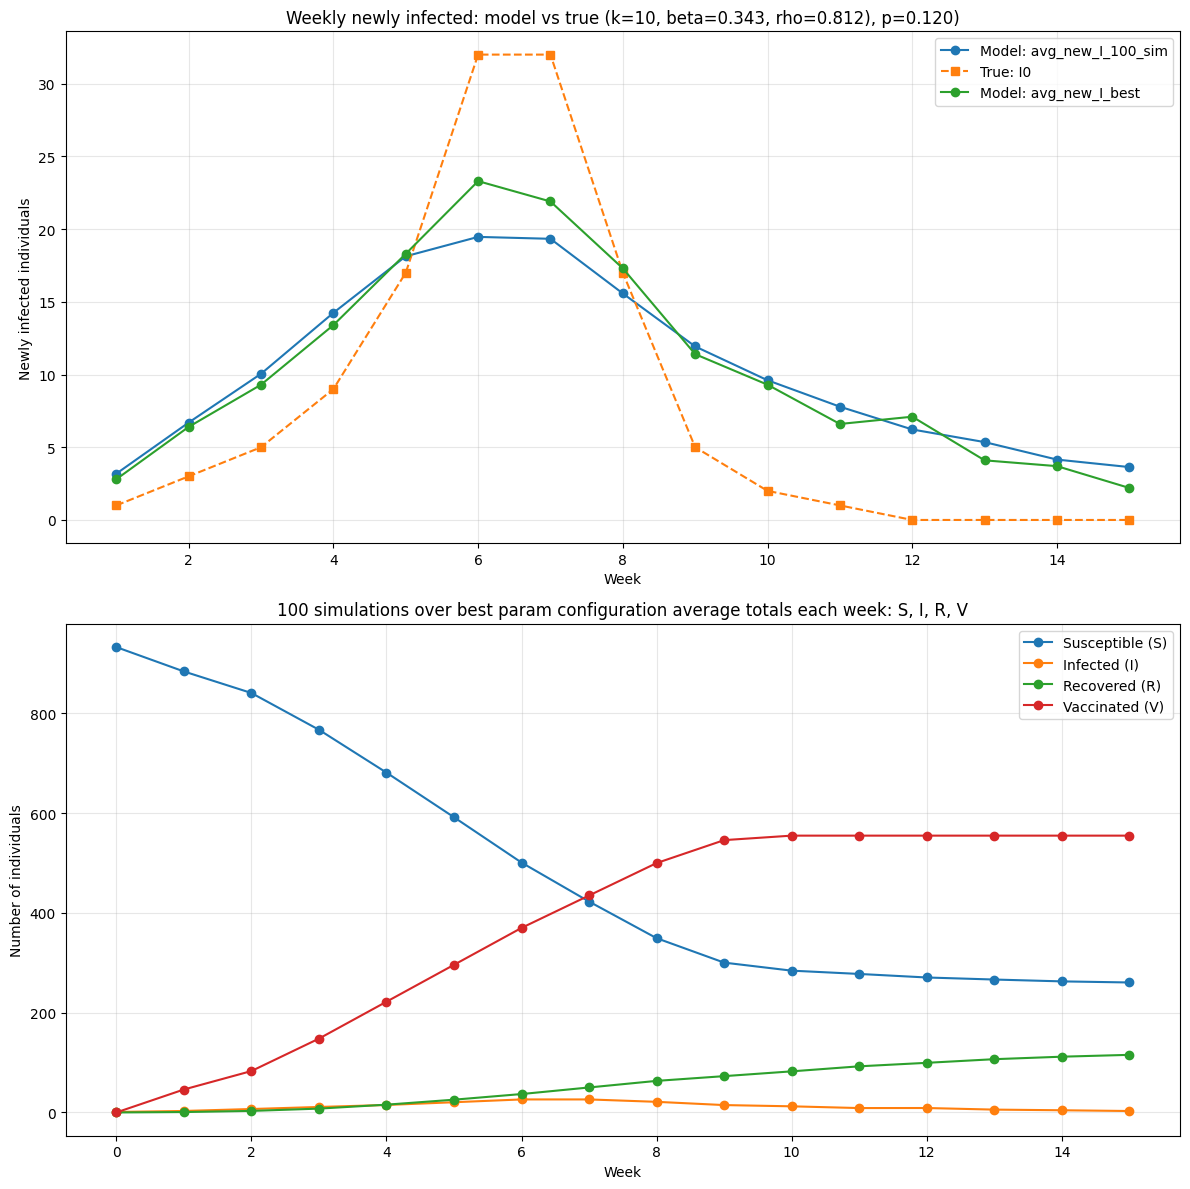

In [33]:
plt.figure(figsize=(12, 12))

# Simulation results vs true data
plt.subplot(2, 1, 1)
plt.plot(range(1, WEEKS + 1), avg_new_I_sim[1:], marker='o', linestyle='-', label='Model: avg_new_I_100_sim')
plt.plot(range(1, WEEKS + 1), I0[1:],        marker='s', linestyle='--', label='True: I0')
plt.plot(range(1, WEEKS + 1), avg_new_I[1:], marker='o', linestyle='-', label='Model: avg_new_I_best')
plt.title(f'Weekly newly infected: model vs true (k={k_best}, beta={beta_best:.3f}, rho={rho_best:.3f}), p={p_best:.3f})')
plt.xlabel('Week')
plt.ylabel('Newly infected individuals')
plt.grid(True, alpha=0.3)
plt.legend()

# S, I, R, V totals
plt.subplot(2, 1, 2)
plt.plot(range(0, WEEKS + 1), avg_S, marker='o', label='Susceptible (S)')
plt.plot(range(0, WEEKS + 1), avg_I, marker='o', label='Infected (I)')
plt.plot(range(0, WEEKS + 1), avg_R, marker='o', label='Recovered (R)')
plt.plot(range(0, WEEKS + 1), avg_V, marker='o', label='Vaccinated (V)')
plt.title('100 simulations over best param configuration average totals each week: S, I, R, V')
plt.xlabel('Week')
plt.ylabel('Number of individuals')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

#### Holme-Kim params estimation and plot

In [34]:
params_init = [10,  0.3, 0.6, 0.1]          # k0, beta0, rho0, p
steps_init  = [3,   0.1, 0.1, 0.01]         # dk, db, dr
min_steps   = [1,   0.01, 0.01, 0.005]      # min_dk, min_db, min_dr
p_types     = [int, float, float, float]    # types
p_bounds    = [
    # Bounds: k >= 2, 0 <= beta <= 1, 0 <= rho <= 1
    (2, None), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0)
]

def simulate_holme_kim(k, beta, rho, p):
    return simulate(k, beta, rho, p, graph_generation_func=generate_holme_kim, n_simulations=N)

best_result = fit_generic_adaptive_steps(
    simulate_func=simulate_holme_kim,
    initial_params=params_init,
    initial_steps=steps_init,
    min_steps=min_steps,
    bounds=p_bounds,
    param_types=p_types,
    shrink=0.5,
    max_iters=200
)

rmse_best = best_result[0]
k_best, beta_best, rho_best, p_best = best_result[1]
avg_new_I, avg_S, avg_I, avg_R, avg_V = best_result[2:]


Iter 0: Best RMSE=22.4546 at (7, 0.200, 0.700, 0.110) | steps: [3, 0.1000, 0.1000, 0.0100]
Iter 1: Best RMSE=4.2837 at (10, 0.100, 0.700, 0.100) | steps: [3, 0.1000, 0.1000, 0.0100]
Iter 2: Best RMSE=4.4967 at (10, 0.100, 0.800, 0.090) | steps: [3, 0.1000, 0.1000, 0.0100]
Iter 3: Best RMSE=3.4807 at (10, 0.100, 0.700, 0.080) | steps: [3, 0.1000, 0.1000, 0.0100]
Iter 4: Best RMSE=5.8631 at (7, 0.100, 0.800, 0.080) | steps: [3, 0.1000, 0.1000, 0.0100]
Iter 5: Best RMSE=2.8753 at (10, 0.100, 0.800, 0.070) | steps: [3, 0.1000, 0.1000, 0.0100]
Iter 6: Best RMSE=5.9380 at (10, 0.100, 0.900, 0.060) | steps: [3, 0.1000, 0.1000, 0.0100]
Iter 7: Best RMSE=6.6607 at (10, 0.100, 0.800, 0.060) | steps: [3, 0.1000, 0.1000, 0.0100]
Iter 8: Best RMSE=4.2117 at (10, 0.100, 0.800, 0.070) | steps: [3, 0.1000, 0.1000, 0.0100]
Iter 9: Best RMSE=3.3343 at (10, 0.100, 0.800, 0.060) | steps: [3, 0.1000, 0.1000, 0.0100]
Iter 10: Best RMSE=5.8653 at (7, 0.100, 0.700, 0.070) | steps: [3, 0.1000, 0.1000, 0.0100]


In [35]:
print("\n=== BEST PARAMETERS (global minimum found) ===")
print(f"k = {k_best}")
print(f"beta = {beta_best}")
print(f"rho = {rho_best}")
print(f"p = {p_best}")
print(f"RMSE = {rmse_best:.4f}")

rmse, avg_new_I_sim, avg_S_sim, avg_I_sim, avg_R_sim, avg_V_sim = simulate(
     k_best, beta_best, rho_best, p_best, graph_generation_func=generate_holme_kim, n_simulations=100
    )


=== BEST PARAMETERS (global minimum found) ===
k = 9
beta = 0.1025
rho = 0.7725
p = 0.11
RMSE = 3.1941


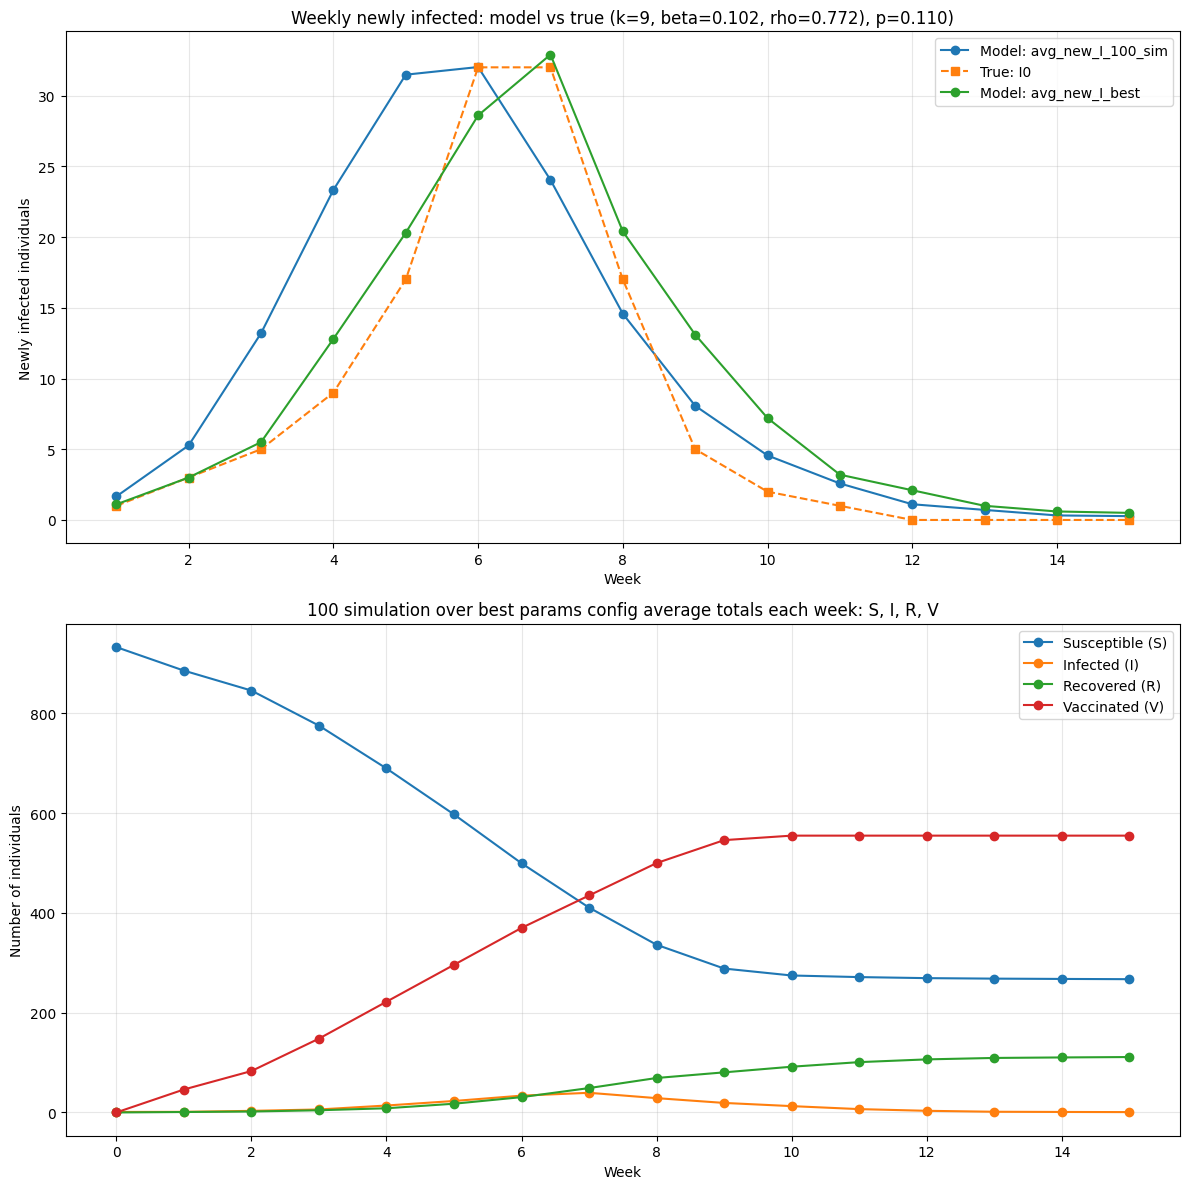

In [36]:
plt.figure(figsize=(12, 12))

# Simulation results vs true data
plt.subplot(2, 1, 1)
plt.plot(range(1, WEEKS + 1), avg_new_I_sim[1:], marker='o', linestyle='-', label='Model: avg_new_I_100_sim')
plt.plot(range(1, WEEKS + 1), I0[1:],        marker='s', linestyle='--', label='True: I0')
plt.plot(range(1, WEEKS + 1), avg_new_I[1:], marker='o', linestyle='-', label='Model: avg_new_I_best')
plt.title(f'Weekly newly infected: model vs true (k={k_best}, beta={beta_best:.3f}, rho={rho_best:.3f}), p={p_best:.3f})')
plt.xlabel('Week')
plt.ylabel('Newly infected individuals')
plt.grid(True, alpha=0.3)
plt.legend()

# S, I, R, V totals
plt.subplot(2, 1, 2)
plt.plot(range(0, WEEKS + 1), avg_S, marker='o', label='Susceptible (S)')
plt.plot(range(0, WEEKS + 1), avg_I, marker='o', label='Infected (I)')
plt.plot(range(0, WEEKS + 1), avg_R, marker='o', label='Recovered (R)')
plt.plot(range(0, WEEKS + 1), avg_V, marker='o', label='Vaccinated (V)')
plt.title('100 simulation over best params config average totals each week: S, I, R, V')
plt.xlabel('Week')
plt.ylabel('Number of individuals')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

## 2

In [37]:
N_PLAYERS = 3
ACTIONS = [1, -1]
N_ACTIONS = len(ACTIONS)
N_STEPS = 100
N_SIMULATIONS = 10000
BURN_IN = 10

n_states_tuple = tuple(N_ACTIONS for _ in range(N_PLAYERS))
n_config = N_ACTIONS ** N_PLAYERS
BETA = 6.0

In [38]:
def get_utility(player_idx, config_tuple, n1):
    u = 0
    is_coordinator = player_idx < n1

    for j in range(N_PLAYERS):
        if j == player_idx: continue

        if is_coordinator:
            val = 0.5 * abs(config_tuple[player_idx] + config_tuple[j])
        else:
            val = 0.5 * abs(config_tuple[player_idx] - config_tuple[j])
        u += val
    return u


def build_Lambda(n1):
    Lambda = sp.sparse.lil_matrix((n_config, n_config))

    for x_id in range(n_config):
        x_indices = np.unravel_index(x_id, shape=n_states_tuple) # Converts numeric index in a tuple of indices
        x_indices = np.array(x_indices)

        # Mapping indices -> real values
        current_config = [ACTIONS[k] for k in x_indices]

        for player in range(N_PLAYERS):
            utilities = []
            for action_idx, action_val in enumerate(ACTIONS):
                y_config = list(current_config)
                y_config[player] = action_val
                utilities.append(get_utility(player, y_config, n1))

            # Best Response Set
            max_u = max(utilities)
            br_indices = [idx for idx, u in enumerate(utilities) if u == max_u]

            # Compute choice probability
            prob_choice = 1.0 / len(br_indices)

            for action_idx in br_indices:
                if action_idx == x_indices[player]:
                    continue

                y_indices = np.copy(x_indices)
                y_indices[player] = action_idx
                y_id = np.ravel_multi_index(tuple(y_indices), dims=n_states_tuple)

                Lambda[x_id, y_id] += 1.0 * prob_choice

    return Lambda


# Using the 2nd approach of CTMC
def simulation(Lambda, start_id, N_STEPS=100):    
    Lambda_dense = Lambda.toarray()
    n_states = Lambda_dense.shape[0]

    w = np.sum(Lambda_dense, axis=1)


    for i in range(n_states):
        if w[i] == 0: # absorbing state, no changes
            w[i] = 1.0
            Lambda_dense[i, i] = 1.0

    P = Lambda_dense / w[:, None]


    states = np.zeros(N_STEPS, dtype=int)
    transition_times = np.zeros(N_STEPS)

    states[0] = start_id
    current_id = start_id
    current_time = 0.0

    # simulation cycle
    for i in range(1, N_STEPS):
        t_next = -np.log(np.random.rand()) / w[current_id]

        current_time += t_next
        transition_times[i] = current_time

        probs = P[current_id, :]
        next_id = np.random.choice(n_states, p=probs)
        states[i] = next_id
        current_id = next_id

    return transition_times, states

# For better visualization
def get_label(x_id):
        idx = np.unravel_index(x_id, n_states_tuple)
        return "".join(["+" if ACTIONS[k]==1 else "-" for k in idx])

In [39]:
def solver(n1, title_suffix):
    print(f"{title_suffix} (n1={n1})")

    start_indices = (0, 1, 0) # initial state (1, -1, 1)
    start_id = np.ravel_multi_index(start_indices, dims=n_states_tuple)

    Lambda = build_Lambda(n1)

    # Transition graph
    G = nx.DiGraph()
    cx = Lambda.tocoo() # convert to Coordinate format for easy iteration
    for i, j, v in zip(cx.row, cx.col, cx.data):
        G.add_edge(get_label(i), get_label(j), weight=v)


    # Compute stationary distribution
    total_time_in_state = defaultdict(float)
    total_valid_time = 0.0
    for i in range(N_SIMULATIONS):
        times, traj = simulation(Lambda, start_id, N_STEPS)
        for k in range(len(traj) - 1):
            if k < BURN_IN: 
                continue # Skip the initial transition

            state = traj[k]
            duration = times[k+1] - times[k]

            total_time_in_state[state] += duration
            total_valid_time += duration

    results = {}
    for state_id, time_spent in total_time_in_state.items():
        if time_spent > 0:
            results[get_label(state_id)] = time_spent / total_valid_time

    sorted_labels = sorted(results.keys())
    sorted_probs = [results[lbl] for lbl in sorted_labels]

    print("\nResults:")
    for lbl, prob in zip(sorted_labels, sorted_probs):
        if prob > 1e-4:
            print(f"  State {lbl}: {prob:.4f}")


    # Simulation for plotting
    times, traj = simulation(Lambda, start_id, N_STEPS)


    # Plot simulation
    plt.figure(figsize=(10, 4))
    plt.step(times, traj, where='post', color='blue', marker='o', markersize=4, linewidth=1.5)
    plt.yticks(range(n_config), [get_label(i) for i in range(n_config)])
    plt.title(f"Traiettoria (Sparse Matrix)\n{title_suffix}")
    plt.xlabel("Time")
    plt.grid(True, alpha=0.3)
    plt.show()

    # Plot transition graph
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G, seed=42, k=1.5)
    nx.draw_networkx(G, pos, node_color='lightgray', node_size=1500, edgecolors='black')
    edge_labels = {(u, v): f"{1/N_PLAYERS * d['weight']:.2f}" for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edges(G, pos, arrowstyle='-|>', arrowsize=15, edge_color='gray')

    nx.draw_networkx_edge_labels(
        G, pos, 
        edge_labels=edge_labels, 
        font_size=8, 
        label_pos=0.6,
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.7)
    )
    plt.axis('off')
    plt.title(f"Transition Graph\n{title_suffix}")
    plt.show()

Pure cooridination (n1=3)

Results:
  State +++: 0.6657
  State ---: 0.3343


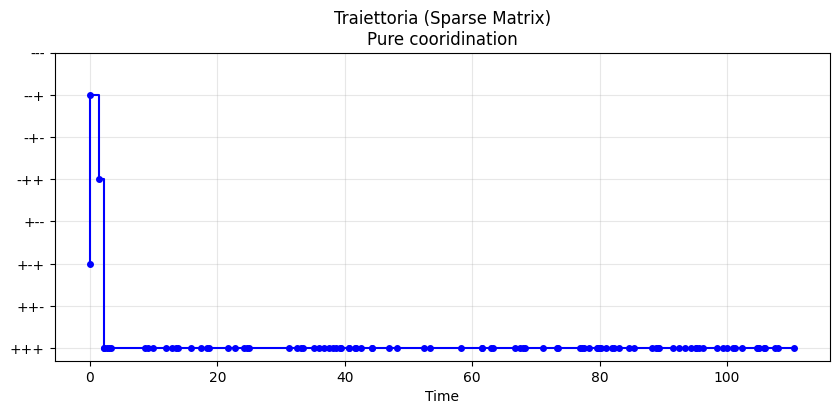

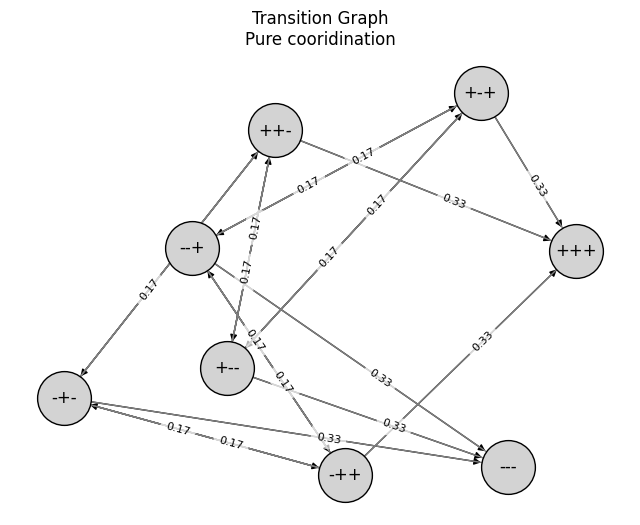

In [40]:
solver(3, "Pure cooridination")

Anti-Coordination (n1=0)

Results:
  State ++-: 0.1677
  State +-+: 0.1685
  State +--: 0.1651
  State -++: 0.1685
  State -+-: 0.1644
  State --+: 0.1659


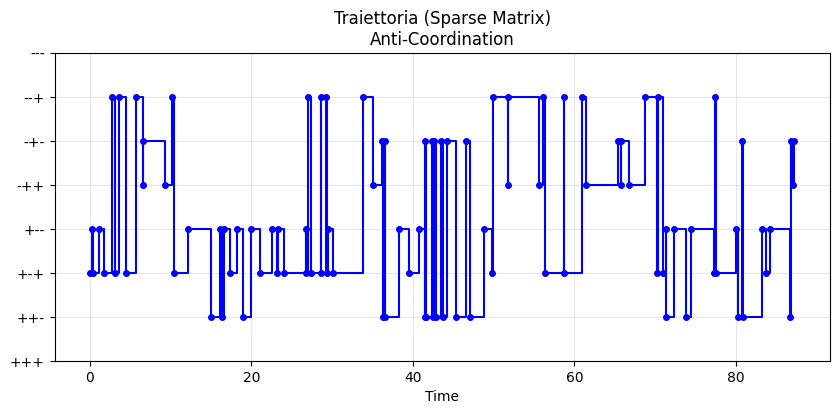

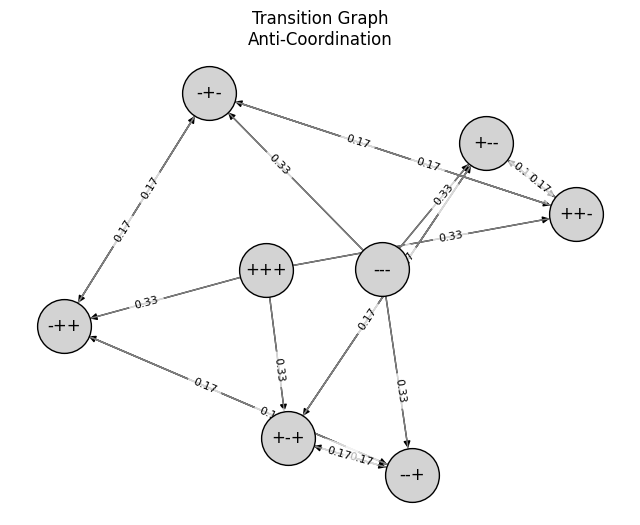

In [41]:
solver(0, "Anti-Coordination")

### Noisy Dynamics Best Response

with $\beta \rightarrow \infty$ (vanishing noise)

In [42]:
# List of all states
ALL_STATES = list(itertools.product(ACTIONS, repeat=N_PLAYERS))

def build_Lambda_noisy(n1, beta):
    Lambda = sp.sparse.lil_matrix((n_config, n_config))

    for x_id in range(n_config):
        x_indices = np.unravel_index(x_id, shape=n_states_tuple)
        x_indices = np.array(x_indices)

        current_config = [ACTIONS[i] for i in x_indices]

        for player in range(N_PLAYERS):
            utilities = np.zeros(N_ACTIONS)
            for action_idx, action_val in enumerate(ACTIONS):
                y_config = list(current_config)
                y_config[player] = action_val
                utilities[action_idx] = get_utility(player, y_config, n1)

            # exp(beta * U)
            exp_utilities = np.exp(beta * utilities)
            sum_exp = np.sum(exp_utilities)

            for action_idx, action_val in enumerate(ACTIONS):
                if action_idx == x_indices[player]:
                    continue

                y_indices = np.copy(x_indices)
                y_indices[player] = action_idx
                y_id = np.ravel_multi_index(tuple(y_indices), dims=n_states_tuple)

                Lambda[x_id, y_id] += exp_utilities[action_idx] / sum_exp

    return Lambda


def noisy_solver(n1, title_suffix):
    print(f"{title_suffix} (n1={n1})")

    start_indices = (0, 1, 0) # initial state (1, -1, 1)
    start_id = np.ravel_multi_index(start_indices, dims=n_states_tuple)

    Lambda = build_Lambda_noisy(n1, BETA)

    total_time_in_state = defaultdict(float)
    total_valid_time = 0.0
    for i in range(N_SIMULATIONS):
        times, traj = simulation(Lambda, start_id, N_STEPS)
        for k in range(len(traj) - 1):
            if k < BURN_IN: 
                continue

            state = traj[k]
            duration = times[k+1] - times[k]

            total_time_in_state[state] += duration
            total_valid_time += duration

    results = {}
    for state_id, time_spent in total_time_in_state.items():
        if time_spent > 0:
            results[get_label(state_id)] = time_spent / total_valid_time

    sorted_labels = sorted(results.keys())
    sorted_probs = [results[lbl] for lbl in sorted_labels]

    print("\nResults:")
    for lbl, prob in zip(sorted_labels, sorted_probs):
        if prob > 1e-4:
            print(f"State {lbl}: {prob:.4f}")

In [43]:
noisy_solver(3, "Pure Coordination")

Pure Coordination (n1=3)

Results:
State +++: 0.4959
State ---: 0.5040


In [44]:
noisy_solver(0, "Pure Anti-Coordination")

Pure Anti-Coordination (n1=0)

Results:
State ++-: 0.1689
State +-+: 0.1692
State +--: 0.1651
State -++: 0.1681
State -+-: 0.1643
State --+: 0.1645


with theory using:

$$
\lim_{\beta \to \infty} \lim_{t \to \infty} P(X(t) = x) = \lim_{\beta \to \infty} \pi_x = 
\begin{cases} 
\frac{1}{|\argmax \Phi|} & \text{if } x \in \argmax \Phi \\
0 & \text{otherwise} 
\end{cases}
$$

In [45]:
def get_potential_and_states(n1):
    states_data = []

    # all possible states
    for x_id in range(n_config):
        x_indices = np.unravel_index(x_id, shape=n_states_tuple)
        config = [ACTIONS[k] for k in x_indices]

        total_utility = sum(get_utility(i, config, n1) for i in range(N_PLAYERS))

        potential = 0.5 * total_utility # because each link is counted twice

        label = "".join(["+" if c==1 else "-" for c in config])
        states_data.append({'id': x_id, 'label': label, 'potential': potential})

    return states_data


def verify_theoretical_limit(n1):
    states_data = get_potential_and_states(n1)

    max_pot = max(s['potential'] for s in states_data)

    max_states = [s for s in states_data if np.isclose(s['potential'], max_pot)]

    prob_theoretical = 1.0 / len(max_states)

    print(f"Max potential: {max_pot}")
    print(f"State at max potential: {len(max_states)}")
    print(f"Theoretical probability: {prob_theoretical:.4f} on")
    for s in max_states:
        print(f"   * {s['label']}")

In [46]:
verify_theoretical_limit(3)

Max potential: 3.0
State at max potential: 2
Theoretical probability: 0.5000 on
   * +++
   * ---


In [47]:
verify_theoretical_limit(0)

Max potential: 2.0
State at max potential: 6
Theoretical probability: 0.1667 on
   * ++-
   * +-+
   * +--
   * -++
   * -+-
   * --+
